# Prototype of gold recovery percentage estimator

This project is for [Zyfra](https://www.zyfra.com/).  

Zyfra is a company that develops and implements industrial digital solutions based on its own platform [ZIIoT](https://www.zyfra.com/product/industrial-iot-platform/), provides access to the development environment for platform applications and evolves the robotic industrial transport industry.  

We have the data provided by the company on gold extraction from ore using [flotation](https://www.911metallurgist.com/blog/flotation) process.  
My goal is to build a model to estimate the percentage of gold recovered from the ore based on various features (e.g. airflow, floatbank level, etc.).  

**Table of Contents:**
* [Project initialization](#1)
    * [1.1 Import Libraries](#1.1)
    * [1.2 Loading dataset](#1.2)

**Table of Contents:**
* [1 Import Libraries and Preprocess the Data](#1)
    * [1.1 Import Libraries](#1.1)
    * [1.2 Import Data](#1.2)
    * [1.3 Ensure Recovery is Correctly Calculated](#1.3)
    * [1.4 Identify Features not in Test Set](#1.4)
    * [1.5 Preprocess the Data](#1.5)
        * [1.5.1 Examine the Data](#1.5.1)
        * [1.5.2 Check for Duplicates](#1.5.2)
        * [1.5.3 Check for Rows Containing Missing Values](#1.5.3)
        * [1.5.4 Scale the Data](#1.5.4)
        * [1.5.5 Fill NaNs for Features & Drop Remaining Rows With NaNs](#1.5.5)
        * [1.5.6 Preprocessing Conclusion](#1.5.6)
* [2 Analyze the Data](#2)
    * [2.1 Examine Concentrations of Metals at Each Purification Stage](#2.1)
    * [2.2 Compare Feed Particle Size Distributions](#2.2)
    * [2.3 Compare Total Substance Concentrations at Different Stages](#2.3)
    * [2.4 Remove Outliers](#2.4)
        * [2.4.1 Select Outlier Rows From Main DataFrame](#2.4.1)
        * [2.4.2 Check New Distributions](#2.4.2)
        * [2.4.3 Remove Outliers from Training and Testing Datasets](#2.4.3)
    * [2.5 Data Analysis Conclusion](#2.5)
* [3 Build Models](#3)
    * [3.1 Create Functions to Calculate sMAPE & Final sMAPE](#3.1)
    * [3.2 Separate Features and Targets for Training and Testing Datasets](#3.2)
    * [3.3 Train and Evaluate Regression Models](#3.3)
    * [3.4 Use Cross Validation to Confirm Results](#3.4)
    * [3.5 Test the Best Model on Testing Datasets](#3.5)
    * [3.6 Check Score Against Sanity Check Model](#3.6)
* [4 Conclusion](#4)

**Data description**  



**Technological process**  

    Rougher feed — raw material
    Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
        Xanthate — promoter or flotation activator;
        Sulphate — sodium sulphide for this particular process;
        Depressant — sodium silicate.
    Rougher process — flotation
    Rougher tails — product residues
    Float banks — flotation unit
    Cleaner process — purification
    Rougher Au — rougher gold concentrate
    Final Au — final gold concentrate

**Parameters of stages**  

    air amount — volume of air
    fluid levels
    feed size — feed particle size
    feed rate

**Feature naming**  

Here's how the features are named:  
*[stage].[parameter_type].[parameter_name]*  
Example: *rougher.input.feed_ag*  
Possible values for *[stage]*:  

    rougher — flotation
    primary_cleaner — primary purification
    secondary_cleaner — secondary purification
    final — final characteristics

Possible values for *[parameter_type]*:

    input — raw material parameters
    output — product parameters
    state — parameters characterizing the current state of the stage
    calculation — calculation characteristics

## Project initialization

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from numpy.random import RandomState
from scipy.stats import t
from scipy.stats import pearsonr
import sidetable
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')

### Loading dataset

In [3]:
df_recovery_train = None
df_recovery_test = None
df_recovery_full = None
try:
    df_recovery_train = pd.read_csv("gold_recovery_train.csv")
    df_recovery_test = pd.read_csv("gold_recovery_test.csv")
    df_recovery_full = pd.read_csv("gold_recovery_full.csv")
except:
    df_recovery_train = pd.read_csv("/datasets/gold_recovery_train.csv")
    df_recovery_test = pd.read_csv("/datasets/gold_recovery_test.csv")
    df_recovery_full = pd.read_csv("/datasets/gold_recovery_full.csv")

In [4]:
df_train = df_recovery_train
df_test = df_recovery_test
df_full = df_recovery_full

In [5]:
display(df_recovery_train.info())
display(df_recovery_test.info())
display(df_recovery_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


None

In [6]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [7]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


We see that in the *date* column both df_train and df_full sets have values that are a round hour and df_test has values at 59:59.  
We'll check if that is true for all rows in the preprocessing step

### Verifying recovery

In [9]:
df_train.dropna(subset=['rougher.output.recovery']).shape

(14287, 87)

In [10]:
df_train['rougher.output.recovery'].isnull().sum()

2573

We have over 2.5K missing values in the recovery column

Let's write a fucntion to calculate the recovery using the formula:

$\begin{align*}
  Recovery &= \frac{C * (F - T)}{F * (C - T)}* 100\%\\ 
\end{align*}$


and then use it to both verify the integrity of the non empty values and to fill in those which are empty

In [11]:
def recovery(df, C, F, T):
    rec = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return rec

We first will calculate the values only for those rows that are not empty in order to verify already existing values

In [12]:
#drop out rows with NaN values and pass in parameters as in the formula
recovery_verify_series = recovery(df_train.dropna(subset=['rougher.output.recovery']),
                     'rougher.output.concentrate_au',
                     'rougher.input.feed_au',
                     'rougher.output.tail_au')

In [13]:
recovery_verify_series.shape

(14287,)

Now let's look at the results

In [14]:
sample_recovery = recovery_verify_series.sample(10, random_state=12345)
display(sample_recovery)

4629     85.250901
2056     -0.000000
13933    89.876611
660      80.943615
6176     85.496577
9423     84.170558
7242     85.874769
15309    81.109587
14796    78.861084
4422     88.339361
dtype: float64

Now we'll look at the corresponding values in the train dataset

In [15]:
#getting the same row numbers through indices of the sample we already collected
df_train['rougher.output.recovery'].iloc[sample_recovery.index]

4629     85.250901
2056      0.000000
13933    89.876611
660      80.943615
6176     85.496577
9423     84.170558
7242     85.874769
15309    81.109587
14796    78.861084
4422     88.339361
Name: rougher.output.recovery, dtype: float64

Now lets see the difference between them using mean absolute error

In [16]:
mean_absolute_error(df_train['rougher.output.recovery'].dropna(),
                    recovery_verify_series)

9.303415616264301e-15

That's a really small number, probably caused by differences in precision of computers handing small fractions of numbers.  
Lets also plot a historam of the difference to ensure there low sum isn't caused by positive and negative numbers cancelling each other

**Conclusion:**  

All the values in differece are extremely low.  
We can safely assume that:  
**The recovery column is calculated correctly**

### Analyzing missing features in test test

In [17]:
columns_not_in_df_test = [x for x in df_full.columns if x not in df_test.columns]
columns_not_in_df_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

It looks like all the values the are missing in test set are outputs and concentrates of metals that can be measured only after the process.  
We still need them as targets for the test set, so we will add them from the df_full dataset in the preprocessing step.  

<br/>

However there are 2 columns that seem to be features of the input and not output:  
* rougher.calculation.floatbank10_sulfate_to_au_feed
* rougher.calculation.floatbank11_sulfate_to_au_feed

I shall create a list of features that containes them as well as all other columns that exists in the test set

In [18]:
columns_features = list(df_test.drop("date", axis=1).columns).copy()
for item in (
    'rougher.calculation.floatbank10_sulfate_to_au_feed',
    'rougher.calculation.floatbank11_sulfate_to_au_feed'):
    columns_features.append(item)

### Preprocessing

#### Analyzing and fixing date column

We previously saw that part of the values in the column were round hours, while other parts were at 59:59 minute at hour.  
Lets take a look at all the values

In [19]:
df_train["date"] = df_train["date"].astype("datetime64")
df_test["date"] = df_test["date"].astype("datetime64")
df_full["date"] = df_full["date"].astype("datetime64")

In [20]:
# df_full.info

<AxesSubplot:>

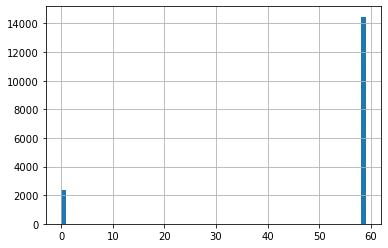

In [21]:
df_train["date"].dt.minute.hist(bins=60)

<AxesSubplot:>

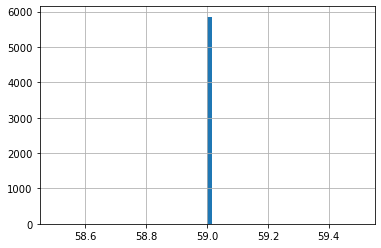

In [22]:
df_test["date"].dt.minute.hist(bins=60)

<AxesSubplot:>

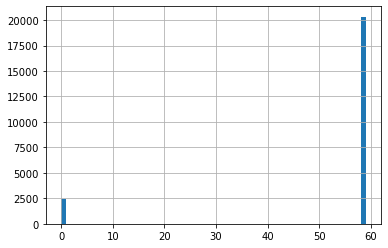

In [23]:
df_full["date"].dt.minute.hist(bins=60)

It looks like there are only 2 values: 0 and 59 minutes  
We can round all the time to round hours

In [24]:
df_train["minute"] = df_train["date"].dt.minute
df_test["minute"] = df_test["date"].dt.minute
df_full["minute"] = df_full["date"].dt.minute

In [25]:
type(df_full["date"].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [26]:
df_full.duplicated(subset=["date"], keep="first").sum()

0

Lets write a function to round the time in our case

In [27]:
def fix_time(row):
    if row["minute"] == 0:
        return row["date"]
    return row["date"] + timedelta(seconds=1)

We'll use it on all of our sets

In [28]:
df_train["date"] = df_train.apply(fix_time, axis=1)
df_test["date"] = df_test.apply(fix_time, axis=1)
df_full["date"] = df_full.apply(fix_time, axis=1)

Need to check we didn't get duplicates in the date field now due to our fix

In [29]:
df_train.duplicated(subset=["date"], keep="first").sum()

0

In [30]:
df_test.duplicated(subset=["date"], keep="first").sum()

0

In [31]:
df_full.duplicated(subset=["date"], keep="first").sum()

0

We see that there are no duplicate times after our fix.  
Now we can safely remove the temp *minute* column we created.

In [32]:
df_train = df_train.drop('minute', axis=1)
df_test = df_test.drop('minute', axis=1)
df_full = df_full.drop('minute', axis=1)

#### Adding features targets to test set

Lets first ensure we have a correspoding date in df_full for every record in our test set

In [33]:
columns_in_df_test = df_test.columns

In [34]:
df_full_features = df_full[df_test.columns]

In [35]:
list_date_full = list(df_full_features['date'])
list_date_test = list(df_test['date'])

In [36]:
list_date_in_test_and_full = [x for x in list_date_full if x in list_date_test]
display(list_date_in_test_and_full[:5])

[Timestamp('2016-09-01 01:00:00'),
 Timestamp('2016-09-01 02:00:00'),
 Timestamp('2016-09-01 03:00:00'),
 Timestamp('2016-09-01 04:00:00'),
 Timestamp('2016-09-01 05:00:00')]

In [37]:
#printing size of the test set
len(list_date_test)

5856

In [38]:
#printing size of the full set
len(list_date_full)

22716

In [39]:
print(f'We have {len(list_date_in_test_and_full)} elements in both lists')

We have 5856 elements in both lists


Looks like all the dates that are in test set are in full set as well

We'll merge the target columns from full dataset with the test set into a new temp set and then we'll only take the targets from there

In [40]:
columns_not_in_df_test.append('date')

In [41]:
df_full_targets = df_full[columns_not_in_df_test]

In [42]:
df_test = df_test.merge(df_full_targets, on="date")
display(df_test.sample(5, random_state=12345))
print(f'Shape of the test set now: {df_test.shape}')

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
5012,2017-11-26 21:00:00,198.238357,10.991582,7.08,2.008978,1599.978357,-499.931560,1598.857403,-500.057486,1599.985210,...,20.754147,88.553380,4.614707,0.689048,19.147768,1.567017,18.656884,7.366024,6.801976,4.494902
3201,2017-09-12 10:00:00,187.685715,8.020792,7.02,0.892078,1301.752604,-503.955823,1297.673879,-499.634237,1296.851378,...,19.126239,86.796047,3.298641,0.558304,19.035235,1.304332,17.238592,7.249225,7.337381,3.291180
4632,2017-11-11 01:00:00,148.685271,9.959004,8.47,1.892180,1598.159719,-503.204830,1601.797695,-502.643701,1478.193261,...,19.502795,84.803458,5.844371,0.598724,25.426692,2.129164,19.904278,4.632018,5.302170,3.364029
2333,2016-12-07 06:00:00,222.145769,9.488381,7.15,1.284743,1502.807962,-500.009535,1500.379611,-499.972527,1501.227618,...,21.512991,87.505567,7.222247,0.424130,15.581072,2.205365,17.480346,4.270753,11.445622,2.456205
5028,2017-11-27 13:00:00,218.152811,10.976666,7.42,2.192583,1598.790561,-489.345965,1598.655291,-573.576554,1598.207072,...,21.237161,90.992841,5.418090,0.668557,15.456586,1.948201,17.895528,7.932691,5.255158,5.833810


Shape of the test set now: (5856, 87)


Looks like we have all the columns in test set as well now

#### Checking duplicate values

In [43]:
print(f"Duplicate rows in the train set: {df_train.duplicated().sum()}")
print(f"Duplicate rows in the test set: {df_test.duplicated().sum()}")
print(f"Duplicate rows in the full set: {df_full.duplicated().sum()}")

Duplicate rows in the train set: 0
Duplicate rows in the test set: 0
Duplicate rows in the full set: 0


It looks like we don't have duplicate values

#### Dropping excessive coulmns

As now the only columns that appear in *train* and *full* sets but not in *test* set are outputs that won't be used neither as features not as targets we can drop all the excessive columns

In [44]:
# df_train = df_train[df_test.columns]

In [45]:
# df_full = df_full[df_test.columns]

#### Checking missing values

In [46]:
display(df_train.stb.missing().head(20))

,missing,total,percent
rougher.output.recovery,2573,16860,15.260973
rougher.output.tail_ag,2250,16860,13.345196
rougher.output.tail_sol,2249,16860,13.339265
rougher.output.tail_au,2249,16860,13.339265
secondary_cleaner.output.tail_sol,1986,16860,11.779359
rougher.input.floatbank11_xanthate,1904,16860,11.293001
final.output.recovery,1521,16860,9.021352
primary_cleaner.input.sulfate,1307,16860,7.752076
primary_cleaner.input.depressant,1262,16860,7.485172
rougher.calculation.au_pb_ratio,1242,16860,7.366548


In [47]:
display(df_test.stb.missing().head(20))

,missing,total,percent
rougher.output.recovery,546,5856,9.323770
rougher.output.tail_au,487,5856,8.316257
rougher.output.tail_sol,487,5856,8.316257
rougher.output.tail_ag,487,5856,8.316257
final.output.recovery,442,5856,7.547814
rougher.calculation.au_pb_ratio,385,5856,6.574454
rougher.input.floatbank11_xanthate,353,5856,6.028005
primary_cleaner.input.sulfate,302,5856,5.157104
primary_cleaner.input.depressant,284,5856,4.849727
rougher.input.floatbank10_sulfate,257,5856,4.388661


2 of the top 3 missing columns are targets.  
We don't want to assume them because that is what our final model should be able , and assuming targets on the train set would just distort the results.  
So we shall drop all the records with missing targets.  
But the recovery column perhaps can be filled with the formula.  
Before we do that, lets check what values we can when we apply that formula on the rows with missing recovery value

In [48]:
series_recovery_missing_test = recovery(df_train[df_train['rougher.output.recovery'].isna()],
                     'rougher.output.concentrate_au',
                     'rougher.input.feed_au',
                     'rougher.output.tail_au').dropna()
print(f'{len(series_recovery_missing_test)} missing values can be filled with the formula')
print("Sample of the data to be filled:")
display(series_recovery_missing_test[:10])

290 missing values can be filled with the formula
Sample of the data to be filled:


53      1.887421e+02
372    -3.913313e+03
377    -1.163121e+02
560    -1.086185e+00
700    -1.127899e+05
812    -7.843480e+01
835     1.137968e+02
837     1.060889e+02
1148   -3.317745e+02
1149            -inf
dtype: float64

We see numbers that are greater than 100 or less than 0, and infinity.  
These are not valid values for recovery that needs to be 0-100%.  
Let's check if we got those values by chance and how many such faulty values we have.  
But first let's get rid of infinity values, as we won't be able to plot a histogram while we have them

In [49]:
len(series_recovery_missing_test)

290

In [50]:
series_recovery_missing_test = series_recovery_missing_test[series_recovery_missing_test != np.inf]
series_recovery_missing_test = series_recovery_missing_test[series_recovery_missing_test != -np.inf]

<AxesSubplot:ylabel='Density'>

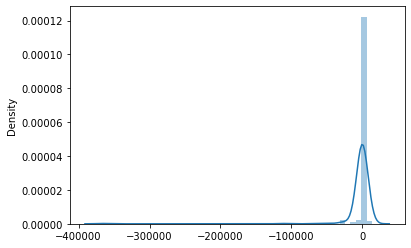

In [51]:
sns.distplot(series_recovery_missing_test)

we see some extremely low values and many values near 0.  
At this scale it is possible that we have many valid values.  
Let's zoom in to see more details

In [52]:
series_recovery_missing_test[(series_recovery_missing_test > -100) & (series_recovery_missing_test < 200)]

53       188.742102
560       -1.086185
812      -78.434804
835      113.796771
837      106.088867
            ...    
16697    112.957805
16698    100.442153
16699     -0.482567
16700     -0.584325
16701     -1.498298
Length: 217, dtype: float64

(-100.0, 200.0)

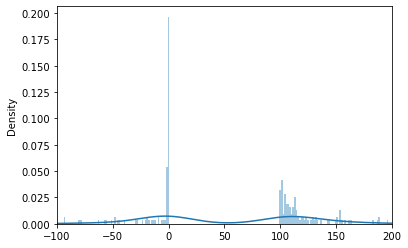

In [53]:
ax = sns.distplot(series_recovery_missing_test[(series_recovery_missing_test > -100) & (series_recovery_missing_test < 200)], bins=200)
ax.set_xlim((-100, 200))

It looks like all the values we can fill will be faulty.  
I suppose the values were empty initially because the value outside of the 0-100% range wouldn't make any sense.  
We can safely drop these columns instead of filling them

In [54]:
df_train = df_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)
df_test = df_test.dropna(subset=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)

In [55]:
display(df_train.stb.missing().head(20))

,missing,total,percent
secondary_cleaner.output.tail_sol,1605,14149,11.343558
rougher.state.floatbank10_e_air,436,14149,3.081490
rougher.input.floatbank11_xanthate,428,14149,3.024949
primary_cleaner.output.concentrate_sol,286,14149,2.021344
secondary_cleaner.state.floatbank2_a_air,217,14149,1.533677
final.output.concentrate_sol,211,14149,1.491271
rougher.input.feed_size,144,14149,1.017740
primary_cleaner.input.xanthate,100,14149,0.706764
rougher.input.feed_pb,100,14149,0.706764
final.output.tail_pb,100,14149,0.706764


In [56]:
display(df_test.stb.missing().head(10))

,missing,total,percent
secondary_cleaner.output.tail_sol,143,5290,2.703214
primary_cleaner.output.concentrate_sol,84,5290,1.587902
primary_cleaner.output.concentrate_pb,30,5290,0.567108
rougher.input.floatbank11_xanthate,25,5290,0.472590
rougher.input.feed_sol,21,5290,0.396975
primary_cleaner.output.tail_sol,16,5290,0.302457
secondary_cleaner.state.floatbank3_a_air,9,5290,0.170132
rougher.input.floatbank11_sulfate,8,5290,0.151229
primary_cleaner.output.tail_pb,6,5290,0.113422
primary_cleaner.input.depressant,5,5290,0.094518


We now see many features missing,  
At least 3% of the datapoints have missing data on some of the features.  
We can either drop the missing values or attempt to fill them in.  
As the data desription says states that "*Some parameters are not available because they were measured and/or calculated much later*" we can fill the missing values with other values that are close enough in time.  
let's take a closer look at the data again

In [57]:
random_index = df_train.sample(1, random_state=1245).index[0]
df_train.iloc[random_index: random_index+10][['date', 'primary_cleaner.state.floatbank8_c_level']]

,date,primary_cleaner.state.floatbank8_c_level
2246,2016-05-11 12:00:00,-500.069761
2247,2016-05-11 13:00:00,-499.415454
2248,2016-05-11 14:00:00,-500.441183
2249,2016-05-11 15:00:00,-499.688503
2250,2016-05-11 16:00:00,-500.399918
2251,2016-05-11 17:00:00,-500.691152
2252,2016-05-11 18:00:00,-499.828075
2253,2016-05-11 19:00:00,-500.795771
2254,2016-05-11 20:00:00,-501.375752
2255,2016-05-11 21:00:00,-499.986032


We see here example of a column that has values that are too disperse despite record are being too close to each other in time of measure.  
That is why I choose to not fill the missing values by assuming it's close to previous recorded data.  
Instead, I will use a Machine-Learning approach to filling in the data:  
Filling the missing data with KNN Imputation as it is logical to assume the in various concentraions of input materials the concentration of other materials would also be similar, and the algorithm has proven itself to be generally effective, according to many sources, for example:  
https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/

#### Data scale
In order to implement KNN it's better to scale the data first,  
As the results are much more precise when the scales are similar

I'll use Standard scaler, so values that are far from the mean would be represented more precisely

In [58]:
feature_scaler = StandardScaler()

In [59]:
columns_to_scale = df_test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1).columns
columns_to_scale

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

In [60]:
columns_to_scale = columns_features.copy()

In [61]:
columns_not_to_scale = [x for x in df_test if x not in columns_to_scale]
display(columns_not_to_scale)

['date',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.t

In [62]:
df_train_scaled = feature_scaler.fit_transform(df_train[columns_to_scale].copy())
df_test_scaled = feature_scaler.transform(df_test[columns_to_scale].copy())

In [63]:
df_train_scaled = pd.DataFrame(df_train_scaled, columns=columns_to_scale)
df_test_scaled = pd.DataFrame(df_test_scaled, columns=columns_to_scale)

In [64]:
columns_combined = list(columns_to_scale.copy())
for item in columns_not_to_scale:
    columns_combined.append(item)
#     print(item)
# columns_combined

In [65]:
df_train[columns_combined]

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,...,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,0.000000,0.000000,0.000000,0.000000
14145,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,-401.195834,...,18.441436,87.724007,4.177943,0.650557,16.960649,0.771582,0.000000,0.000000,0.000000,0.000000
14146,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,-399.988275,...,15.111231,88.890579,4.050010,0.636095,18.323080,0.685059,0.000000,0.000000,0.000000,0.000000
14147,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,...,17.834772,89.858126,3.902494,0.625609,19.423740,0.567130,0.000000,0.000000,0.000000,0.000000


In [66]:
df_train[columns_not_to_scale].reset_index(drop=True)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 07:00:00,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,0.000000,0.000000,0.000000,0.000000
14145,2018-08-18 08:00:00,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,18.441436,87.724007,4.177943,0.650557,16.960649,0.771582,0.000000,0.000000,0.000000,0.000000
14146,2018-08-18 09:00:00,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,15.111231,88.890579,4.050010,0.636095,18.323080,0.685059,0.000000,0.000000,0.000000,0.000000
14147,2018-08-18 10:00:00,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,17.834772,89.858126,3.902494,0.625609,19.423740,0.567130,0.000000,0.000000,0.000000,0.000000


In [67]:
df_train_scaled = pd.concat([df_train_scaled.reindex(),df_train[columns_not_to_scale]], axis=1)
df_test_scaled = pd.concat([df_test_scaled,df_test[columns_not_to_scale]], axis=1)

In [68]:
display(df_train_scaled.sample(5, random_state=12345))
display(df_test_scaled.sample(5, random_state=12345))

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
4899,0.757217,-0.267514,0.621604,0.369264,-0.074923,-0.313693,-0.047014,-0.326984,-0.046815,-0.264371,...,19.262950,85.590094,5.663056,0.627349,18.461484,1.809670,13.086033,3.317501,7.254092,1.915541
4590,-0.938955,0.015486,0.273092,-0.374347,-0.060892,-0.316521,-0.068171,-0.322980,-0.084819,-0.310080,...,22.028052,87.935562,5.766882,0.550860,15.156680,1.875881,11.456979,4.871395,7.431252,5.537773
4350,1.024654,1.729172,1.559652,-1.217132,0.708410,-0.312919,0.710920,-0.331549,-0.062679,-0.284436,...,20.783923,90.307108,5.902046,0.425147,18.617839,1.715387,15.392030,2.974415,11.754433,4.006274
2390,-0.231855,0.946128,1.185085,-0.288343,-3.192210,-0.332690,-3.113540,-0.329655,-3.046393,-0.294930,...,23.592553,77.748329,6.878389,0.776580,17.391207,2.655799,18.040952,3.998420,12.544656,6.680282
8804,-0.101020,-0.997297,-0.687756,-1.573041,0.707938,-0.317054,-0.029225,-0.330948,0.656756,-0.289347,...,21.781251,71.763262,6.869928,0.903905,17.090477,2.517140,16.911787,7.377528,3.420269,3.598323


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
3059,1.475918,-0.105499,-0.435330,1.281525,-1.226020,-0.241807,-1.215710,-0.436844,-1.209935,-0.330401,...,19.778230,87.770635,3.479621,0.750832,18.752423,1.523363,0.000000,0.000000,0.000000,0.000000
967,-0.018828,-0.417640,-0.313187,1.073443,-0.217498,-0.302401,0.672656,-0.331863,0.668513,-0.313774,...,22.604336,89.000935,6.389726,0.372994,16.553255,1.910554,12.006724,3.818741,10.808008,7.747745
5040,2.784249,1.530650,1.934221,1.763121,-0.428207,-0.328655,-0.439832,-1.381448,-1.340616,0.341290,...,18.733023,94.594986,5.019032,0.586458,20.734748,1.518118,18.093088,8.004338,8.943296,8.232157
5185,-3.191735,NaN,-0.199189,-2.362765,-12.524358,-8.218363,-12.269349,-0.210575,-11.983119,-8.711396,...,19.646963,93.288126,5.525220,0.451630,15.389648,1.743004,17.011648,9.889648,6.882324,6.902627
2990,-0.128265,-0.105099,-0.541186,0.864217,-1.625681,-0.294495,-1.588249,-0.250118,-1.558529,-0.324348,...,19.504175,89.189661,3.167153,0.510040,18.955512,1.132764,15.374298,10.149675,4.138838,7.384561


Scaled datasets look normal now

#### Implementing KNN Imputor

I'll use the scikit-learn *KNNImputer* implementaion of the algorithm

In [69]:
imputer = KNNImputer()

In [70]:
df_train_imputed = pd.DataFrame(
    imputer.fit_transform(df_train_scaled[columns_to_scale]),
    columns = columns_to_scale)

In [71]:
df_test_imputed = pd.DataFrame(
    imputer.transform(df_test_scaled[columns_to_scale]),
    columns = columns_to_scale)

Now we have temp dataframes *df_train_imputed* and *df_test_imputed*.  
We can now assign these dataframes with full values back to the original dataframes

In [72]:
df_train_scaled = pd.concat([df_train_scaled[columns_not_to_scale], df_train_imputed], axis=1)
df_test_scaled = pd.concat([df_test_scaled[columns_not_to_scale], df_test_imputed], axis=1)

In [73]:
display(df_train_scaled.sample(5, random_state=12345))
print(df_train_scaled.shape)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed
4899,2017-01-10 04:00:00,3.712425,8.033828,13.631412,48.473231,70.709139,8.845224,2.632767,10.380058,2.675636,...,-0.649401,-0.687850,-0.443781,-0.430976,-0.872775,-0.418222,0.077601,-2.545477,-0.143777,-0.092793
4590,2016-08-27 23:00:00,5.978141,9.574893,8.422982,44.573758,68.039692,8.567373,3.003479,7.918957,3.592308,...,-1.061696,-0.675186,-1.171217,-0.385991,-1.394756,-0.409191,0.939093,0.192800,-0.205014,-0.144959
4350,2016-08-17 12:00:00,6.090347,9.649611,10.872579,43.291846,77.926649,10.425093,2.459391,9.453206,2.693327,...,-1.053382,1.017705,-0.293628,2.174770,-1.391731,2.125802,0.244143,0.171801,-0.074291,-0.033739
2390,2016-05-17 14:00:00,4.107255,9.388371,10.151618,46.735425,59.416695,10.049323,2.002330,11.214887,3.901251,...,-1.420179,-0.686858,-1.334668,-0.476377,-1.214971,-0.414238,0.074541,0.166013,-0.132069,-0.082454
8804,2017-07-20 07:00:00,3.700473,11.842490,7.167722,45.703119,61.289448,8.039743,3.218959,11.261780,2.938968,...,-0.080153,1.380286,0.215783,-0.427317,-0.013030,-0.408208,-0.793302,0.178596,0.401711,0.373515


(14149, 87)


On the first glance look OK.  
Let's take a look at missing values more mathematically

In [74]:
df_train_scaled.isna().sum()

date                                                    0
final.output.concentrate_ag                             1
final.output.concentrate_pb                             1
final.output.concentrate_sol                          211
final.output.concentrate_au                             0
                                                     ... 
secondary_cleaner.state.floatbank5_b_level              0
secondary_cleaner.state.floatbank6_a_air                0
secondary_cleaner.state.floatbank6_a_level              0
rougher.calculation.floatbank10_sulfate_to_au_feed      0
rougher.calculation.floatbank11_sulfate_to_au_feed      0
Length: 87, dtype: int64

Looks like the only columns with missing values now are outputs which we didn't fill.  
Looks good but let's compare with the original set

In [75]:
df_train.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

Great, we see the difference,  
Now let's check the same values in the test set

In [76]:
df_test_scaled.isna().sum()

date                                                  0
final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
                                                     ..
secondary_cleaner.state.floatbank5_b_level            0
secondary_cleaner.state.floatbank6_a_air              0
secondary_cleaner.state.floatbank6_a_level            0
rougher.calculation.floatbank10_sulfate_to_au_feed    0
rougher.calculation.floatbank11_sulfate_to_au_feed    0
Length: 87, dtype: int64

Looks great!  
It looks like we've completed the part of filling missing values.  
Now let's descale the features back, as it was scaled with incomplete data.  
We'll scale them once again later when we need

In [77]:
pd.DataFrame(feature_scaler.inverse_transform(df_train_scaled[columns_to_scale]), columns=columns_to_scale)


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,3481.779053,3520.337158
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,3498.370979,3489.981857
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,3495.348910,3502.359819
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,3498.578313,3499.162912
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,3494.800771,3506.679315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,...,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,2497.652954,2499.177950
14145,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,-401.195834,...,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,2614.403937,2518.550078
14146,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,-399.988275,...,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,2510.813545,2510.142433
14147,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,...,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,2507.572494,2507.723361


In [78]:
df_train[columns_to_scale] = pd.DataFrame(feature_scaler.inverse_transform(
    df_train_scaled[columns_to_scale]), columns=columns_to_scale)
df_test[columns_to_scale] = pd.DataFrame(feature_scaler.inverse_transform(
    df_test_scaled[columns_to_scale]), columns=columns_to_scale)

In [79]:
display(df_train.sample(4, random_state=12345))
display(df_test.sample(4, random_state=12345))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4899,2017-01-10 04:00:00,3.712425,8.033828,13.631412,48.473231,70.709139,8.845224,2.632767,10.380058,2.675636,...,13.991523,-500.874847,12.074159,-500.703556,14.187136,-500.286314,8.032679,-500.363601,20.024847,-601.179514
4590,2016-08-27 23:00:00,5.978141,9.574893,8.422982,44.573758,68.039692,8.567373,3.003479,7.918957,3.592308,...,16.072388,-499.387917,9.907356,-499.958368,9.944949,-498.581784,5.023244,-500.009504,24.990671,-499.649837
4350,2016-08-17 12:00:00,6.090347,9.649611,10.872579,43.291846,77.926649,10.425093,2.459391,9.453206,2.693327,...,18.014157,-401.020413,9.951050,-400.346093,15.062787,-401.550850,5.040687,-400.621257,20.984830,-500.428460
2390,2016-05-17 14:00:00,4.107255,9.388371,10.151618,46.735425,59.416695,10.049323,2.002330,11.214887,3.901251,...,9.935985,-500.429014,8.023361,-500.645150,8.991750,-502.006649,6.059779,-500.207392,20.007208,-500.643078


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
3059,2017-09-23 14:00:00,191.516501,8.512363,7.055,1.363213,1450.591604,-497.408756,1449.221592,-503.851176,1446.430913,...,19.778230,87.770635,3.479621,0.750832,18.752423,1.523363,0.000000,0.000000,0.000000,0.000000
967,2016-10-21 10:00:00,132.578251,7.463113,7.130,1.285660,1580.075568,-499.572139,1696.801654,-500.323478,1698.635415,...,22.604336,89.000935,6.389726,0.372994,16.553255,1.910554,12.006724,3.818741,10.808008,7.747745
5040,2017-12-20 06:00:00,243.104320,14.012229,8.510,1.542704,1553.022707,-500.509477,1550.945496,-535.592945,1428.885473,...,18.733023,94.594986,5.019032,0.586458,20.734748,1.518118,18.093088,8.004338,8.943296,8.232157
5185,2017-12-27 12:00:00,7.469704,3.722114,7.200,0.004984,0.000000,-782.195107,0.000000,-496.247779,0.000000,...,19.646963,93.288126,5.525220,0.451630,15.389648,1.743004,17.011648,9.889648,6.882324,6.902627


Since we performed all the preprocessing step on both train and test sets,  
We can combine them into the full instead on preprocessing it again

In [80]:
df_full = pd.concat([df_train, df_test])

In [81]:
display(df_full.sample(4, random_state=12345))
display(df_full.shape)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5264,2017-02-01 01:00:00,7.066047,9.478443,17.151693,42.590948,62.558084,11.544518,4.099213,10.372322,4.780360,...,25.070707,-502.335251,22.957998,-500.331000,23.014357,-500.282331,20.001374,-500.000961,25.008355,-600.151748
12699,2018-06-04 23:00:00,4.331323,12.471643,5.869074,43.252616,70.664197,8.430734,3.052587,10.295974,1.789147,...,30.022337,-500.350803,21.955005,-499.547955,25.001803,-500.029053,22.974025,-499.873433,24.992422,-499.807232
4329,2016-08-16 15:00:00,6.441173,9.064088,11.273021,43.482633,74.092709,9.838359,2.748540,9.996859,3.466387,...,17.880962,-399.457823,10.029009,-400.402439,14.936650,-395.346330,4.959238,-400.204035,22.990928,-496.222805
558,2016-02-09 18:00:00,4.993571,11.321386,5.691245,43.493480,63.580614,10.676063,1.487393,18.834149,2.309034,...,20.016661,-496.383512,15.964599,-498.280089,18.051289,-500.899548,15.992132,-500.148410,24.973915,-499.066802


(19439, 87)

**Conclusion**  
We filled missing features (targets and all outputs were not filled) with KNN imputer.  
But first we scaled the features and then descaled back to normal once we had the values full.  
And since both train and test sets were altered the df_full dataset is less relevant in the way it is, so we fetched it from combining train and test sets.

## Analyzing the data

### Change of metal concentrations per purification stage

#### Histograms per purification stage: plot per each metal

##### creating supplementary variables and functions

Looking at the data description we need the following columns (each one of them combined with the metal it represents):  
* rougher.input.feed
* rougher.output.concentrate
* primary_cleaner.output.concentrate
* final.output.concentrate

<br/>

And we have the following metals:
* Au - Gold
* Ag - Silver
* Pb - Lead

<br/>
Let's create lists for both of them in order to later feed them to a function and plot the results automatically

In [82]:
list_concentration_prefix = [
    'rougher.input.feed',
    'rougher.output.concentrate',
    'primary_cleaner.output.concentrate',
    'final.output.concentrate'
    ]

list_concentration_names = [
    'Ore mixture',
    'Rougher concentrate',
    'After 1st clean',
    'Final concentrate'
    ]

list_metal_suffix = [
    'au',
    'ag',
    'pb'
    ]

list_metal_names = [
    'Gold',
    'Silver',
    'Lead'
    ]

df_concentrates = pd.DataFrame([list_concentration_prefix, list_concentration_names]).T
df_concentrates.columns=['prefix', 'name']

df_metals = pd.DataFrame([list_metal_suffix, list_metal_names]).T
df_metals.columns=['prefix', 'name']

The functions below will be used in order to set range for bins in histogram

In [83]:
#The functions below will be used in order to set range for bins in histogram

def get_min_conentration_per_metal_at_any_stage(df, metal_suffix):
    return df[[f"{s}_{metal_suffix}" for s in list_concentration_prefix]].min().min()

def get_max_conentration_per_metal_at_any_stage(df, metal_suffix):
    return df[[f"{s}_{metal_suffix}" for s in list_concentration_prefix]].max().max()

In [84]:
def get_legend_names_with_means(metal_name):
    legend_names = []
    for legend_item in [f"{metal_name} {s}" for s in list_concentration_names]:
        legend_names.append(legend_item)
        legend_names.append(f'Mean')
    return legend_names

In [85]:
#plot a single subplot when diving subplots by metals
def plot_concentration_per_stage_single_metal_single_stage_in_subplot(ax, df_to_analyze,
        df_set_name, index_concentrates, metal_suffix, metal_name):
    
    stage_prefix, stage_name = df_concentrates.iloc[index_concentrates]
    series_to_analyze = df_to_analyze[stage_prefix + "_" + metal_suffix]
    
    sns.distplot(series_to_analyze, ax=ax,
        bins=np.linspace(
            get_min_conentration_per_metal_at_any_stage(df_to_analyze, metal_suffix),
            get_max_conentration_per_metal_at_any_stage(df_to_analyze, metal_suffix)
            ,120))
    ax.axvline(x=series_to_analyze.mean(), color=sns.color_palette()[index_concentrates], linestyle='--')
    ax.legend(get_legend_names_with_means(metal_name), bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax.set(
        title=metal_name + ' contentration % per stage in ' + df_set_name + ' set')
    
    ticks = ax.get_xticks()
    xlabels = ['{:,.0%}'.format(x / 100) for x in ticks]
    ax.set_xticklabels(xlabels)
    
    ax.set_xlabel('')

#plot all subplot when diving subplots by metals for already existing axis
def plot_concentration_per_stage_single_metal_all_stages_in_subplot(
        axes, df_to_analyze, index_metal,
        df_set_name):
    
    suffix, metal_name = df_metals.iloc[index_metal]
    for index_concentrates in df_concentrates.index:
        prefix, stage = df_concentrates.iloc[index_concentrates]

        plot_concentration_per_stage_single_metal_single_stage_in_subplot(axes[index_metal], df_to_analyze,
            df_set_name, index_concentrates, suffix, metal_name)

def plot_concentration_per_stage_divided_by_metals(df_to_analyze, df_set_name):
    sns.set(rc = {'figure.figsize':(12,8)})
    sns.set_theme(style='white')
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 14), sharey=False)
    
    fig.suptitle(f'Histograms: Metal concentration per purification stage in {df_set_name} set')#, fontsize=15, y=1)
    
    for index_metal in df_metals.index:
        suffix, metal_name = df_metals.iloc[index_metal]

        plot_concentration_per_stage_single_metal_all_stages_in_subplot(axes,
            df_to_analyze, index_metal,
            df_set_name)
    plt.tight_layout()
    plt.show()

##### Plot

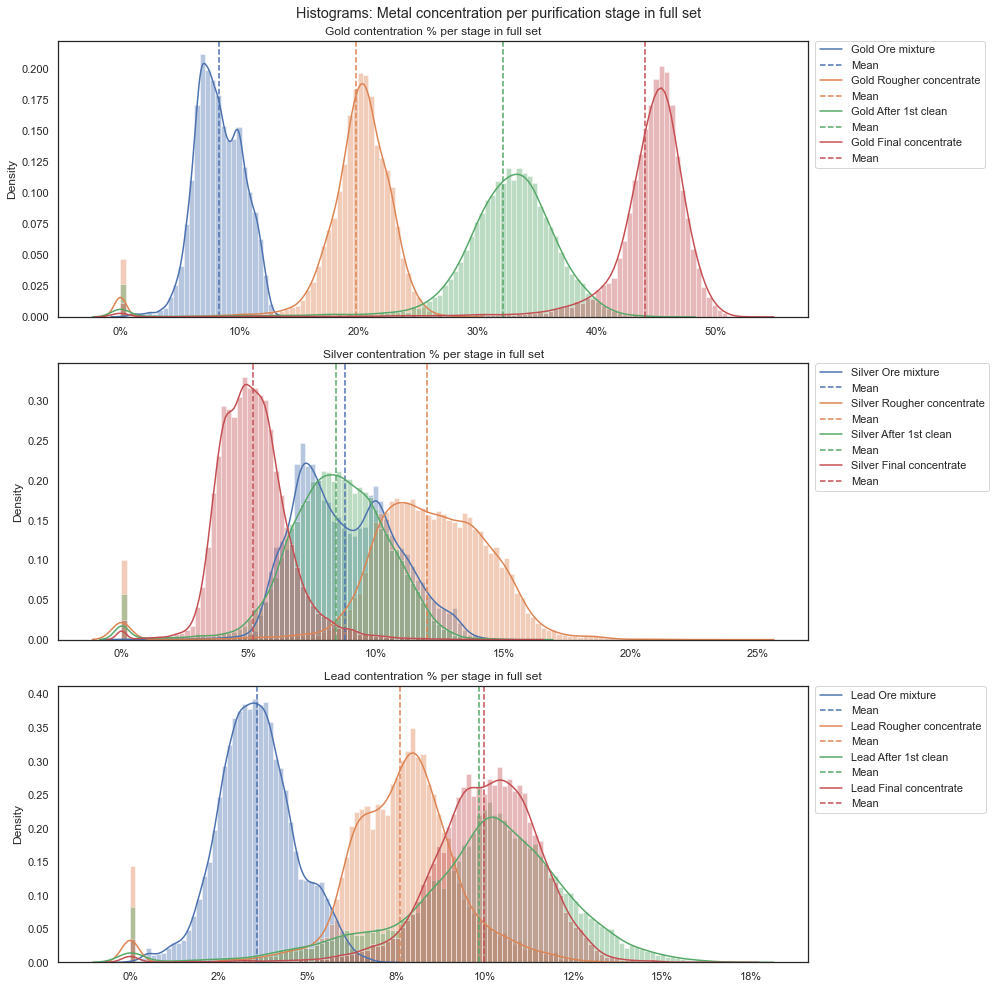

In [86]:
plot_concentration_per_stage_divided_by_metals(df_full, 'full')

##### Insights  
* In gold concentration level all the percentage follow a strict logic: in each following step the concentraion increases.  
  In other metals however The logic is less observed:
  * Silver for instance has the smallest concentration in the final output unlike gold
  * Lead follows gold logic if we look just at the means, but also the mean after the 1st purification is very close to the mean for final output  
  This is probably due to the fact the process focuses on gold extraction more than other metals, so it makes sense
* There are many records with 0% concentration at all stages for all metals, which is probably an anomaly

#### Histograms per metal: plot per each purification stage 

We saw now plot with metal type as a facet column,  
I think it would be a wise idea also to look at plots where each plot is assigned to a purification stage

##### writing supplementary functions

In [87]:
#The functions below will be used in order to set range for bins in histogram

def get_min_conentration_per_stage_for_all_metals(df, concentration_prefix):
    return df[[f"{concentration_prefix}_{m}" for m in list_metal_suffix]].min().min()

def get_max_conentration_per_stage_for_all_metals(df, concentration_prefix):
    return df[[f"{concentration_prefix}_{m}" for m in list_metal_suffix]].max().max()

In [88]:
def get_legend_names_with_means_facet_by_stage(stage_name):
    legend_names = []
    for legend_item in [f"{m} %" for m in list_metal_names]:
        legend_names.append(legend_item)
        legend_names.append(f'Mean of {legend_item}')
    return legend_names

In [89]:
def plot_single_hist_line_per_metal_subplot_facet_by_stage(ax, df_to_analyze,
        df_set_name, index_concentrates, index_metal):
    
    stage_prefix, stage_name = df_concentrates.iloc[index_concentrates]
    metal_suffix, metal_name = df_metals.iloc[index_metal]
    series_to_analyze = df_to_analyze[stage_prefix + "_" + metal_suffix]
    
    sns.distplot(series_to_analyze, ax=ax,
        bins=np.linspace(
            get_min_conentration_per_stage_for_all_metals(df_to_analyze, stage_prefix),
            get_max_conentration_per_stage_for_all_metals(df_to_analyze, stage_prefix)
            ,120))
    ax.axvline(x=series_to_analyze.mean(), color=sns.color_palette()[index_metal], linestyle='--')
    ax.legend(get_legend_names_with_means_facet_by_stage(stage_name), bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax.set(
        title=stage_name + ' stage: contentration % per metal')

In [90]:
def plot_single_subplot_per_metal_subplot_facet_by_stage(
        axes, df_to_analyze, index_concentrates,
        df_set_name):
    
    stage_prefix, stage_name = df_concentrates.iloc[index_concentrates]
    for index_metal in df_metals.index:
        suffix, metal_name = df_metals.iloc[index_metal]

        plot_single_hist_line_per_metal_subplot_facet_by_stage(axes[index_concentrates],
            df_to_analyze,
            df_set_name,
            index_concentrates,
            index_metal)
        axes[index_concentrates].set_xlabel('')
        
        ticks = axes[index_concentrates].get_xticks()
        xlabels = ['{:,.0%}'.format(x / 100) for x in ticks]

        axes[index_concentrates].set_xticklabels(xlabels)

In [91]:
def plot_concentration_per_metals_facet_by_stage(df_to_analyze, df_set_name):
    sns.set(rc = {'figure.figsize':(12,8)})
    sns.set_theme(style='white')
    fig, axes = plt.subplots(nrows=len(df_concentrates.index), ncols=1, figsize=(14, 14), sharey=False)
    
    fig.suptitle(f'Histograms: Metal concentrations per each purification stage in {df_set_name} set')
    for index_concentrates in df_concentrates.index:
        plot_single_subplot_per_metal_subplot_facet_by_stage(
            axes,
            df_to_analyze,
            index_concentrates,
            df_set_name)
    plt.tight_layout()
    plt.show()

##### plot

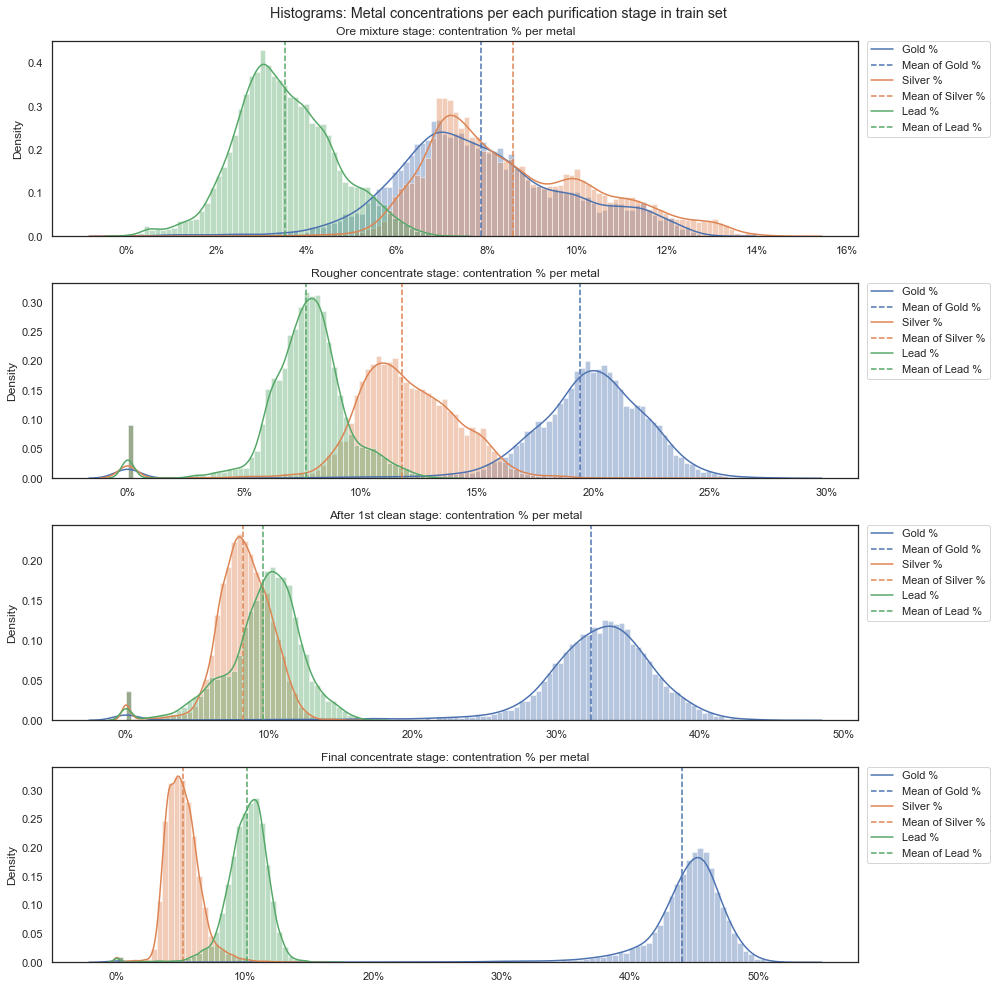

In [92]:
plot_concentration_per_metals_facet_by_stage(df_train, "train")

##### Insights
* Lead starts with lowest concentration among the metals
* At rougher concentrate all metals have higher conentration than in the feed
* After the first purification step the metals behave differently: 
  * silver concentration starts to decrease
  * gold concentration increases
  * lead concentrate stays relatively the same
* Gold concentraion increses at each stage, which of course makes sense as the main goal of the process is gold extraction
* We see here again the outliers around around 0% 
* The only plot with no such anomality is Ore mixture feed concentrarion
* If we are about to drop the extra small outliers we see here that some of the distributions here are closer to 0 than others, so we'll probably have to set up a few thresholds depending on metal/stage
* I'll address how to deal with the anomaly in a later stage in this notebook

### Comparing train and test sets

#### Metal concentrations in the feed

We already have plots for metal concentratio in the feed.  
Let's now tweak them a little bit so we see difference between the sets

##### functions

In [93]:
dict_sets = {"Var" : [df_train, df_test], "Name" : ['train', 'test']}

In [94]:
def plot_single_hist_line_per_share1_subplot(ax, df_to_analyze,
        df_set_name, index_concentrates, index_metal):
    
    stage_prefix, stage_name = df_concentrates.iloc[index_concentrates]
    metal_suffix, metal_name = df_metals.iloc[index_metal]
    series_to_analyze = df_to_analyze[stage_prefix + "_" + metal_suffix]
    
    sns.distplot(series_to_analyze, ax=ax,
        bins=np.linspace(
            df_full[stage_prefix + "_" + metal_suffix].min(),
            df_full[stage_prefix + "_" + metal_suffix].max(),
            120),
        color=sns.color_palette()[index_metal])
    ax.axvline(x=series_to_analyze.mean(), color=sns.color_palette()[index_metal], linestyle='--')
    ax.legend([metal_name + ' %', 'mean'], bbox_to_anchor=(0.985, 0.98), loc=1, borderaxespad=0.)
    ax.set(
        title=metal_name + ' % in ' + stage_name + ' stage')
    ax.set_ylabel(f'{df_set_name} set')
    ax.set_xlabel('')

In [95]:
def plot_share_x_subplots_cross_set_for_single_stage(index_concentrates):
    stage_prefix, stage_name = df_concentrates.iloc[index_concentrates]

    sns.set(rc = {'figure.figsize':(12,8)})
    sns.set_theme(style='white')
    fig, axes = plt.subplots(nrows=2, ncols=len(df_metals), figsize=(16, 8), sharey=False)
    
    #share x axis per column
    for i in range(len(df_metals)):
        axes[1][i].sharex(axes[0][i])
        axes[1][i].sharey(axes[0][i])

    fig.suptitle(f'Histograms: Metal concentrations in {stage_name} stage in per set')

    for index_dataset in range(len(dict_sets)):
        df_to_analyze, df_set_name = dict_sets["Var"][index_dataset], dict_sets["Name"][index_dataset]

        for index_metal in df_metals.index:
            suffix, metal_name = df_metals.iloc[index_metal]
            ax = axes[index_dataset][index_metal]
            plot_single_hist_line_per_share1_subplot(ax, df_to_analyze,
                    df_set_name, index_concentrates, index_metal)

    plt.tight_layout()
    plt.show()

##### Plot

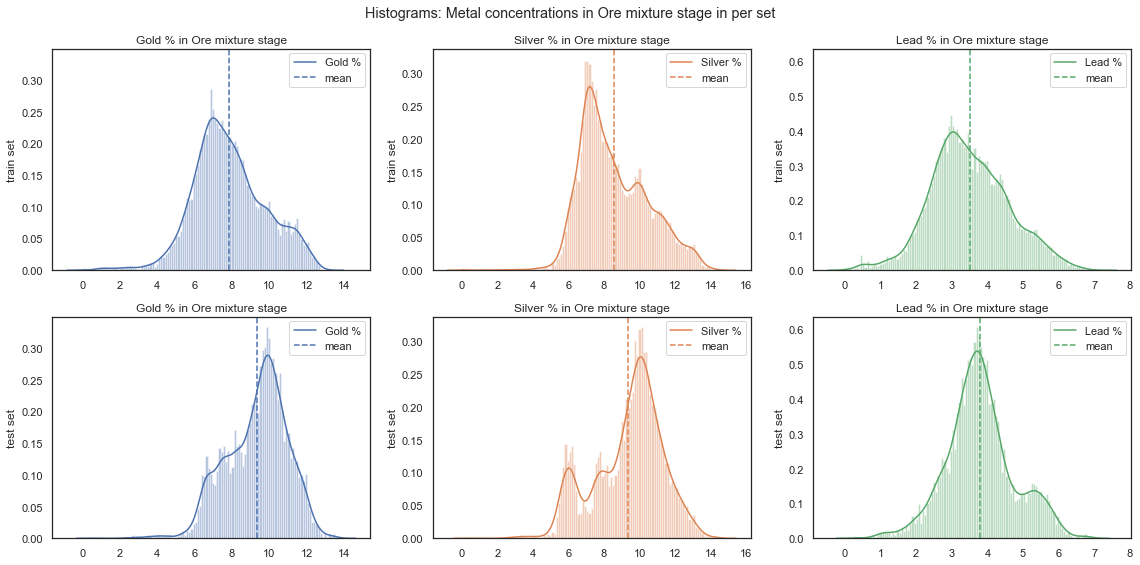

In [96]:
plot_share_x_subplots_cross_set_for_single_stage(0)

##### Insights
We see that there is some difference in the sets, but not sure if significant.  
I'll plot the difference per each metal and stage so we can see more details.

#### Plotting differences between the datasets for every metal and stage

##### functions

In [97]:
def plot_single_hist_line_per_share1_subplot_single_metal(ax, df_to_analyze,
        df_set_name, index_concentrates, index_metal):
    
    stage_prefix, stage_name = df_concentrates.iloc[index_concentrates]
    metal_suffix, metal_name = df_metals.iloc[index_metal]
    series_to_analyze = df_to_analyze[stage_prefix + "_" + metal_suffix]
    
    sns.distplot(series_to_analyze, ax=ax,
        bins=np.linspace(
            df_full[stage_prefix + "_" + metal_suffix].min(),
            df_full[stage_prefix + "_" + metal_suffix].max(),
            120),
        color=sns.color_palette()[index_concentrates])
    ax.axvline(x=series_to_analyze.mean(), color=sns.color_palette()[index_concentrates], linestyle='--')
    ax.legend([metal_name + ' %', 'mean'],
              bbox_to_anchor=(0.02, 0.985),
              loc=2,
              borderaxespad=0.)
    ax.set(
        title=metal_name + ' % in ' + stage_name + ' stage')
    ax.set_ylabel(f'{df_set_name} set')
    ax.set_xlabel('')

In [98]:
def plot_share_x_subplots_cross_set_for_single_metal(index_metal):
    suffix, metal_name = df_metals.iloc[index_metal]

    sns.set(rc = {'figure.figsize':(12,8)})
    sns.set_theme(style='white')

    fig, axes = plt.subplots(nrows=2, ncols=len(df_concentrates), figsize=(16, 8), sharey=False)

    #share x axis per column
    for i in range(len(df_concentrates)):
        axes[1][i].sharex(axes[0][i])
        axes[1][i].sharey(axes[0][i])

    fig.suptitle(f'Histograms: {metal_name} concentrations in divided by stages, columns per different sets')

    for index_dataset in range(len(dict_sets)):
        df_to_analyze, df_set_name = dict_sets["Var"][index_dataset], dict_sets["Name"][index_dataset]

        for index_concentrates in df_concentrates.index:
            plot_single_hist_line_per_share1_subplot_single_metal(
                axes[index_dataset][index_concentrates], df_to_analyze,
                df_set_name, index_concentrates, index_metal)

    plt.tight_layout()
    plt.show()

##### Plots

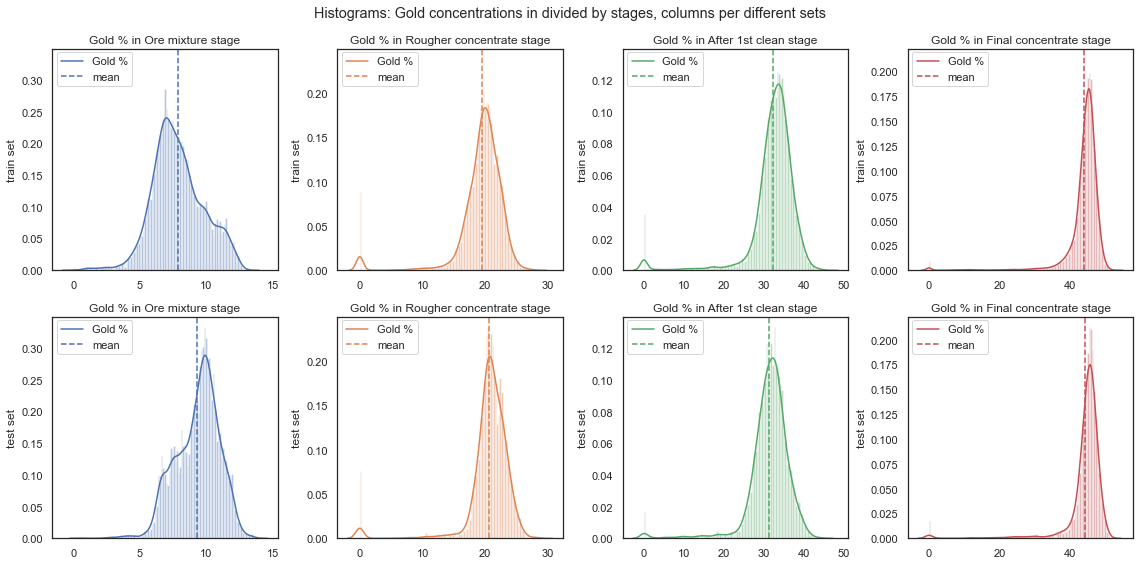

In [99]:
plot_share_x_subplots_cross_set_for_single_metal(0)

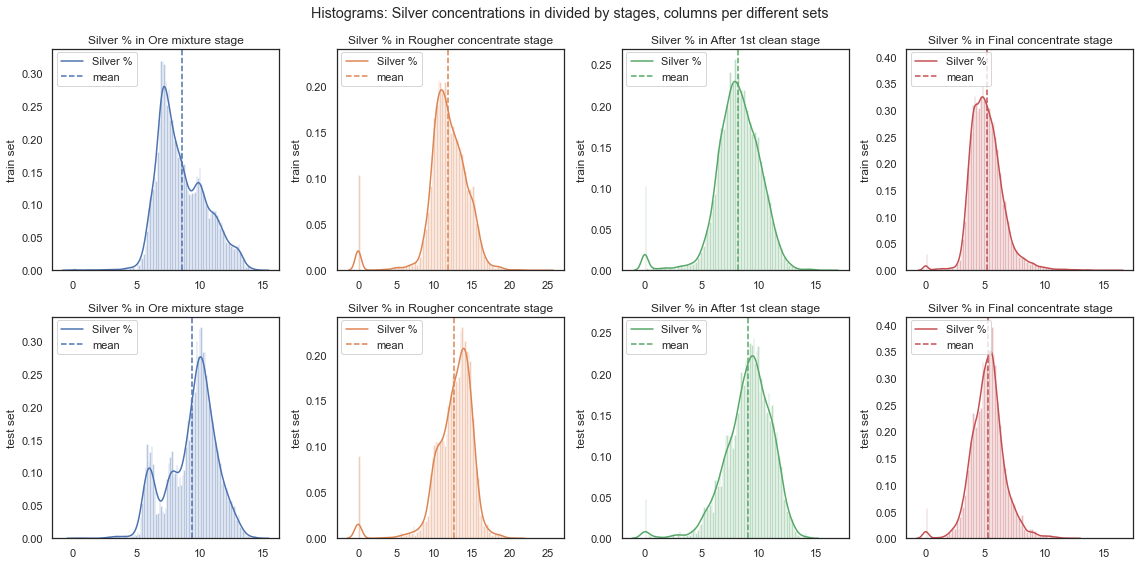

In [100]:
plot_share_x_subplots_cross_set_for_single_metal(1)

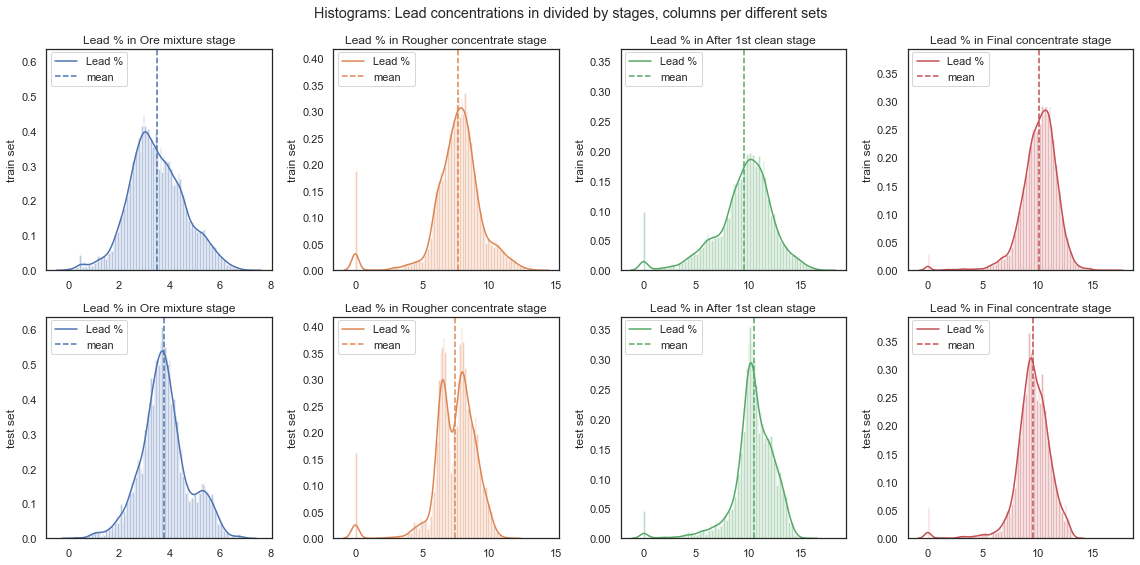

In [101]:
plot_share_x_subplots_cross_set_for_single_metal(2)

##### Insights

It looks like most of the differences we see come from the difference in the feed.  
So our next step will be comparing the feed sizes

#### Values of the feed size variables

We already have in our datasets the following variables:
* *primary_cleaner.input.feed_size* - Primary feed size
* *rougher.input.feed_size* - Rougher feed size

We'll use them to compare the feed sizes between the train and the test sets

##### Writing supplementary functions

In [102]:
df_feeds = pd.DataFrame({'column' : ['primary_cleaner.input.feed_size', 'rougher.input.feed_size'],
    "name" : ['Primary feed size', 'Rougher feed size']})
display(df_feeds)

,column,name
0,primary_cleaner.input.feed_size,Primary feed size
1,rougher.input.feed_size,Rougher feed size


In [103]:
def plot_hist_line_for_feed_size(axes,index_dataset, index_feeds):
    df_to_analyze, df_set_name = dict_sets["Var"][index_dataset], dict_sets["Name"][index_dataset]
    feed_column, feed_name = df_feeds.loc[index_feeds]
    ax=axes[index_dataset][index_feeds]
    xlim = np.quantile(df_full[feed_column], [0.002, 0.99])
    sns.distplot(df_to_analyze[feed_column],
        ax=ax,
        color=sns.color_palette()[index_feeds],
        bins=np.linspace(xlim[0], xlim[1], 60))
    ax.axvline(x=df_to_analyze[feed_column].mean(), color=sns.color_palette()[index_feeds], linestyle='--')
    ax.set(title=feed_name)
    ax.set_xlabel('')
    ax.set_ylabel(f'{df_set_name} set')
    ax.set_xlim(xlim)

In [104]:
def plot_distplots_for_feed_sizes_using_subplots():
    sns.set(rc = {'figure.figsize':(12,8)})
    sns.set_theme(style='white')

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharey=False)

    #share x axis per column
    for i in range(len(df_feeds)):
        axes[1][i].sharex(axes[0][i])
        axes[1][i].sharey(axes[0][i])

    fig.suptitle(f'Feed sizes comparison in train and test sets')

    for index_dataset in range(len(dict_sets)):
        for index_feeds in  range(len(df_feeds)):
            plot_hist_line_for_feed_size(axes, index_dataset, index_feeds)
    plt.tight_layout()
    plt.show()

##### Plot

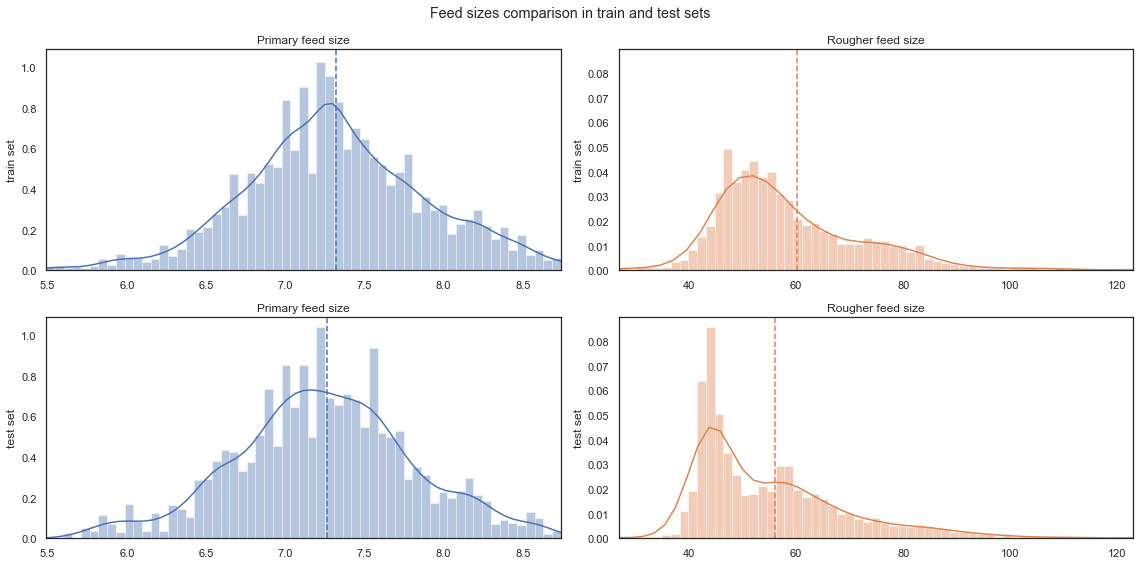

In [105]:
plot_distplots_for_feed_sizes_using_subplots()

##### Insights
Visually the difference between the feed sizes looks insignificant

### Addressing the anomaly in the total concentrations of all substances at different stages

#### The anomaly

Looking at the plots of metals at different stages we saw almost at all stages (except for the raw feed) concentraion of 0% of the measured metals.  
considering that we didn't see such abnormal values in the raw feed metal concentrations, these outliers most probable are caused by data filling errors, perhaps there was no clear value so instead the value was 0.  
There could be other reasons for the error as well.  
But the chance to get 0% of metals from process that its goal is to purify these metals is etremely low.  
So I'll remove these outliers as errors in the data.  


However,  
If we are about to drop the extra small outliers we need to consider that some of the distributions are closer to 0 than the others.  
So we'll probably have to set up a few thresholds depending on metal/stage.  

Let's plot the distribution along with their percentiles in order to take a more mathematical approach to decide which values to consider as outliers

#### Plotting the distributions with their percentiles

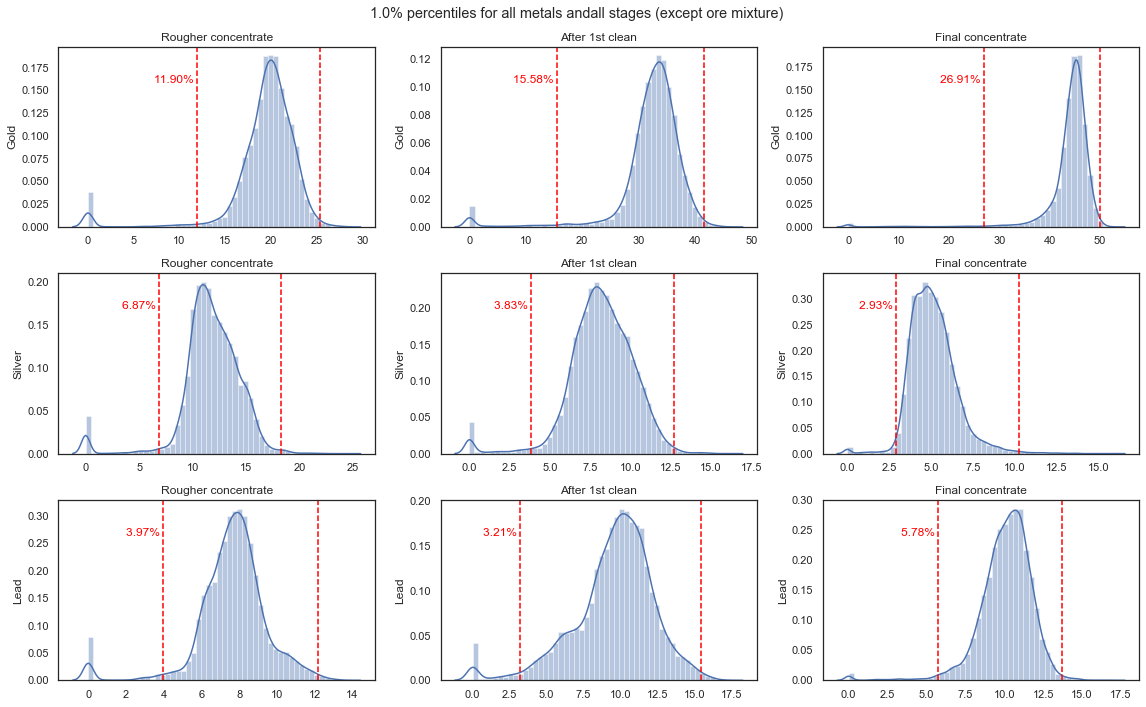

In [106]:
percentiles_to_check = (0.01, 0.995)

sns.set_theme(style='white')

fig, axes = plt.subplots(nrows=len(df_metals), ncols=len(df_concentrates) - 1, figsize=(16, 10), sharey=False)

fig.suptitle('{:.1%} percentiles for all metals andall stages (except ore mixture)'.format(percentiles_to_check[0]))

df_to_analyze = df_train
df_set_name = "train"
for index_metal, (suffix, metal_name) in df_metals.iterrows():
    for index_concentrates in range(1, len(df_concentrates)):
        prefix, stage_name = df_concentrates.iloc[index_concentrates]
        ax = axes[index_metal][index_concentrates - 1]
        series = df_to_analyze[f'{prefix}_{suffix}']
        sns.distplot(
            series,
            ax=ax)
        limits = np.quantile(series[series > 1], percentiles_to_check)
        ax.axvline(x=limits[0], color='red', linestyle='--')
        ax.axvline(x=limits[1], color='red', linestyle='--')

        ax.text(limits[0], ax.get_ylim()[1] * 0.8, "{:.2f}% ".format(limits[0]),
                color='red',
                horizontalalignment='right')

        ax.set(title=stage_name)
        ax.set_xlabel('')
        ax.set_ylabel(f'{metal_name}')

plt.tight_layout()
plt.show()

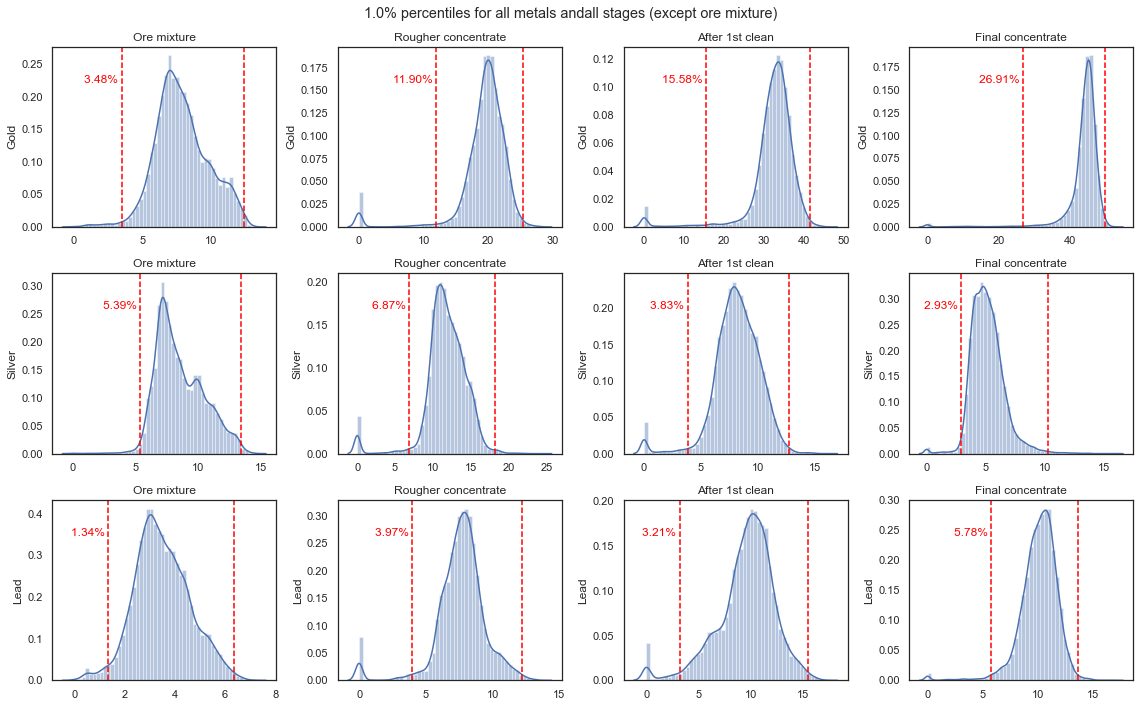

In [107]:
percentiles_to_check = (0.01, 0.995)

sns.set_theme(style='white')

fig, axes = plt.subplots(nrows=len(df_metals), ncols=len(df_concentrates), figsize=(16, 10), sharey=False)

fig.suptitle('{:.1%} percentiles for all metals andall stages (except ore mixture)'.format(percentiles_to_check[0]))

df_to_analyze = df_train
df_set_name = "train"
for index_metal, (suffix, metal_name) in df_metals.iterrows():
    for index_concentrates in range(0, len(df_concentrates)):
        prefix, stage_name = df_concentrates.iloc[index_concentrates]
        ax = axes[index_metal][index_concentrates]
        series = df_to_analyze[f'{prefix}_{suffix}']
        sns.distplot(
            series,
            ax=ax)
        limits = np.quantile(series[series > 1], percentiles_to_check)
        ax.axvline(x=limits[0], color='red', linestyle='--')
        ax.axvline(x=limits[1], color='red', linestyle='--')

        ax.text(limits[0], ax.get_ylim()[1] * 0.8, "{:.2f}% ".format(limits[0]),
                color='red',
                horizontalalignment='right')

        ax.set(title=stage_name)
        ax.set_xlabel('')
        ax.set_ylabel(f'{metal_name}')

plt.tight_layout()
plt.show()

#### Decision based on the plot results
We see that for the absolute majority of the distribution it's safe to remove every value below 5% of concentration,  as they represent less than 1% of the data.  

However the following metal concentration distributions  are less safe to remove with 5% threshold as values below represent more than 1%:
 * Silver in primary_cleaner.output.concentrate
 * Silver in final.output.concentrate 	
 * Lead in rougher.output.concentrate
 * Lead in primary_cleaner.output.concentrate

we see though that for these concentrations it's safe to remove values below 3%


So our Thresholds go as follow:
* 5% for most of the concentration distributions
* 3% for the remaining ones mentioned above

In [108]:
df_concentrates

,prefix,name
0,rougher.input.feed,Ore mixture
1,rougher.output.concentrate,Rougher concentrate
2,primary_cleaner.output.concentrate,After 1st clean
3,final.output.concentrate,Final concentrate


#### Removing outliers

In [109]:
columns_with_lower_threshold = [
    'primary_cleaner.output.concentrate_ag',
    'final.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'primary_cleaner.output.concentrate_pb',
    ]

df_thresholds = pd.DataFrame()
for item_c in df_concentrates['prefix'][1:]:
    df_thresholds = pd.concat([df_thresholds, pd.DataFrame([item_c + "_" + df_metals['prefix'].values]).T])
df_thresholds.columns=['concentrate']
df_thresholds = df_thresholds.reset_index(drop=True)
df_thresholds['threshold'] = 5

df_thresholds.loc[df_thresholds.query('concentrate in @columns_with_lower_threshold').index, 'threshold'] = 3

df_thresholds

,concentrate,threshold
0,rougher.output.concentrate_au,5
1,rougher.output.concentrate_ag,5
2,rougher.output.concentrate_pb,3
3,primary_cleaner.output.concentrate_au,5
4,primary_cleaner.output.concentrate_ag,3
5,primary_cleaner.output.concentrate_pb,3
6,final.output.concentrate_au,5
7,final.output.concentrate_ag,3
8,final.output.concentrate_pb,5


In [110]:
len(df_train)

14149

In [111]:
len(df_test)

5290

In [112]:
# df_train = df_train_copy.copy()
# df_test = df_test_copy.copy()

In [113]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [114]:
rows_below_threshold_in_train_set = 0
for index, (concentrate, threshold) in df_thresholds.iterrows():
    rows_below_threshold_in_train_set += len(df_train[df_train[concentrate] <= threshold])
    df_train = df_train[df_train[concentrate] >= threshold]

In [115]:
lost_rows_train = rows_below_threshold_in_train_set / len(df_train)

In [116]:
rows_below_threshold_in_test_set = 0
for index, (concentrate, threshold) in df_thresholds.iterrows():
    rows_below_threshold_in_test_set += len(df_test[df_test[concentrate] <= threshold])
    df_test = df_test[df_test[concentrate] >= threshold]

In [117]:
rows_below_threshold_in_test_set

342

In [118]:
lost_rows_test = rows_below_threshold_in_test_set / len(df_test)

In [119]:
print(f'Train set new size: {len(df_train)}')
print(f'Test set new size: {len(df_test)}')

Train set new size: 13157
Test set new size: 4921


In [120]:
print('Train set data loss due to anomaly: {:.2%}'.format(lost_rows_train))
print('Test set data loss due to anomaly: {:.2%}'.format(lost_rows_test))

Train set data loss due to anomaly: 6.97%
Test set data loss due to anomaly: 6.95%


#### Plotting metal concetration after removing the anomaly

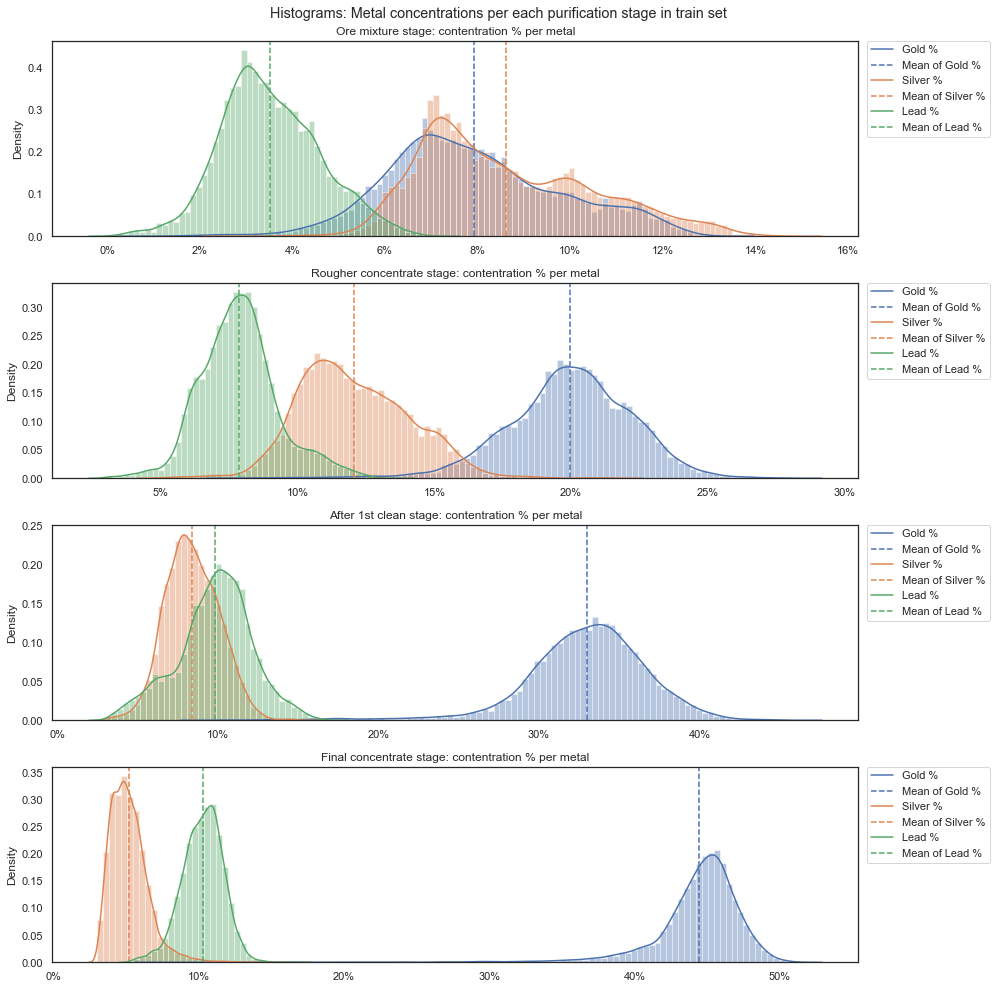

In [121]:
plot_concentration_per_metals_facet_by_stage(df_train, "train")

Now these plots look more natural and make sense

### Conclusion

## Model

### sMAPE functions

In [122]:
def smape_single_target(y_true, y_pred):
    result = 2 * np.mean(abs(y_true - y_pred) / (abs(y_true) + abs(y_pred)))
    return result #2 * np.mean(abs(y_true - y_pred) / (abs(y_true) + abs(y_pred)))

In [123]:
def final_smape(y_true, y_pred):
    answer = 0.25 * smape_single_target(y_true[:,0], y_pred[:,0]) + 0.75 * smape_single_target(y_true[:,1], y_pred[:,1])
    return answer

### Features and targets extraction

We have already done data preprocessing for the EDA.  
Now we'll new a few more preprocessing steps in order to feed our models

In [124]:
columns_targets = [
    'rougher.output.concentrate_au',
    'final.output.concentrate_au'
    ]

In [125]:
X_train = df_train[columns_features]
X_test = df_test[columns_features]
y_train = df_train[columns_targets]
y_test = df_test[columns_targets]

In [126]:
print('Train features sample')
display(X_train.sample(4, random_state=4444))
print('\n\n')
print('Test features sample')
display(X_test.sample(4, random_state=4444))
print('\n\n')
print('Train targets sample')
display(y_train.sample(4, random_state=4444))
print('\n\n')
print('Test targets sample')
display(y_test.sample(4, random_state=4444))

Train features sample


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed
12733,92.637509,7.999524,8.11,0.383147,1598.675163,-499.834901,1536.539074,-447.516857,1601.354093,-500.253342,...,22.008152,-500.083549,24.999939,-500.955319,22.975203,-500.306950,25.004733,-500.603561,2801.405808,2801.015660
12424,114.308302,8.934864,6.05,0.700776,1599.140343,-500.128708,1599.970763,-500.078230,1601.486364,-500.709736,...,20.076746,-499.935806,18.014357,-499.754718,14.000128,-499.826611,14.009202,-499.881834,2789.508329,2789.360898
13890,211.423273,15.001083,6.82,0.973465,1649.036706,-400.800092,1649.695837,-400.307213,1648.989026,-403.020343,...,22.933242,-499.996092,22.950083,-499.653054,18.005317,-499.752532,23.018936,-534.134244,3770.910751,3770.438330
7663,200.007468,7.958998,6.86,0.569848,1636.205529,-500.484088,1631.226806,-500.499958,1646.275059,-498.645655,...,9.873645,-500.699197,14.992944,-501.395587,9.984441,-500.114964,25.000263,-501.385731,3746.866057,3746.987668





Test features sample


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed
2711,123.842500,4.541136,6.90,1.387064,1599.933834,-498.827753,1599.759927,-499.556249,1598.707206,-500.453070,...,9.003385,-400.021299,14.008021,-499.800434,8.424569,-500.021367,15.001470,-500.151538,4956.994356,4956.850098
79,123.796374,7.954799,7.62,0.698720,1298.404944,-501.786130,1299.460739,-499.671802,1297.229131,-502.258985,...,7.847802,-501.545940,8.300304,-495.027680,4.957856,-499.461204,9.974954,-502.294433,2971.160059,2971.732034
1985,129.755182,7.003727,7.59,0.947489,1504.153666,-499.931753,1500.971918,-500.083202,1497.497066,-502.134874,...,15.934684,-500.272997,17.144834,-500.127470,11.982236,-500.403716,22.023293,-501.831508,3108.891131,3108.821885
4807,230.575915,10.011104,8.13,1.084109,1550.217482,-496.146875,1547.778664,-510.734253,1553.475831,-489.764181,...,15.040505,-298.482880,10.954416,-498.921859,8.021618,-499.884161,12.014300,-500.004565,3407.983609,3430.673888





Train targets sample


,rougher.output.concentrate_au,final.output.concentrate_au
12733,15.352455,46.821091
12424,18.363988,43.689293
13890,20.354989,44.872436
7663,23.252334,43.485546





Test targets sample


,rougher.output.concentrate_au,final.output.concentrate_au
2711,20.488965,44.985750
79,23.669568,45.800903
1985,24.366127,44.404807
4807,22.906370,31.247152


### Data scaling

In [127]:
feature_scaler = StandardScaler()

In [128]:
X_train = feature_scaler.fit_transform(X_train)

In [129]:
X_test = feature_scaler.transform(X_test)

In [130]:
y_train = np.array(y_train)

In [131]:
y_test = np.array(y_test)

In [132]:
#print sample of the scaled sets
display(X_train[:2])

array([[-0.20692151,  0.3605006 , -0.13456346,  0.27496635, -0.47449567,
        -0.29913653, -0.45660695, -0.81320875, -0.46408222, -0.27565077,
         0.04834697, -0.21636945, -1.35327459, -1.15351421,  0.47145331,
        -0.20201334,  0.07883298, -0.76739683,  0.06869531,  0.10113223,
         0.11811809,  0.10605122, -0.73805202, -0.34939475,  1.53594318,
         0.50406225,  1.40719583,  0.39931921,  1.84077813,  0.24270028,
         1.70623693,  0.15604852,  2.1582137 ,  0.21423067, -0.66787134,
         0.05864832, -0.17136742,  0.02876331, -0.93904439, -0.32051183,
        -0.14515185, -0.25533168, -1.06428687, -0.48310662, -0.64822402,
        -0.76682903, -1.1851425 , -0.38834457, -0.86765056, -0.43522609,
        -0.96600247, -2.74030306,  0.0148478 ,  0.05023278],
       [-0.24535652,  0.41073369, -0.13456346,  0.31207702, -0.26355701,
        -0.3561542 , -0.26472087, -0.32160934, -0.26306601, -0.29450498,
         0.12040095, -0.33653203, -1.32066085, -1.17112832,  0.

The data looks fine now

### Building supplementary functions

We'll need to create a *scorer* for our sMAPE function in order to use it as a cost function in Grid Search

In [133]:
scorer_smape = make_scorer(final_smape, greater_is_better=False)

We also need a variable to store scores for all our models.  
A pandas DataFrame is a very convenient var type for this purpose

In [134]:
df_model_result = pd.DataFrame(columns=['Model', 'Score on CV', 'Score on Test Tet'])

#### Implementing Cross-Validation Grid Search

First we need a function that implements grid search with cross-validation, fits it to our train set and returns a new model along with results of the grid search.  
I choose to use an already existing function in scikit-learn library called **GridSearchCV**.  
We need to alter only 2 parameters in the function call, so in order to avoid code duplicate I'll create a new function that receives only the 2 following parameters and then feed them to the build-in scikit-learn function:  
* model
* grid_parameters  

Than our function would return an already fit model and also the results of the grid search

In [135]:
def fit_GridSearchCV_model_based_on_existing_model(model, grid_parameters = {}, verbose=1):
    model_gs = GridSearchCV(model, 
                         param_grid=grid_parameters,
                         cv=5,
                         scoring=scorer_smape,
                         verbose=verbose,
                         refit=True,
                         return_train_score=True
                        )
    model_gs.fit(X_train, y_train)
    return model_gs

The model returns many metrics in result.  
Because we need for every model the same metrics I' write a functions that returns only those metrics that we are interested in

#### Plotting validation curve for a hyperparameter

In [136]:
def plot_model_scores(parameter_range, train_scores, test_scores, model_name, parameter_name):
    sns.set(rc={'figure.figsize':(12,6)})
    parameter_range = np.array(parameter_range)
    sns.set_theme(style="darkgrid")
    sns.lineplot(x=parameter_range, y= train_scores, label='train', color='red')
    sns.lineplot(x=parameter_range, y= test_scores, label='validation', color='green')
    plt.axvline(x=parameter_range[test_scores.argmin()], color='blue', linestyle='--')
    text_optimal_value = parameter_range[test_scores.argmin()]
    try:
        int(text_optimal_value)
        text_optimal_value = "{} ".format(text_optimal_value.round(10))
    except:
        pass
    plt.text(parameter_range[test_scores.argmin()], plt.gca().get_ylim()[1] * 1.003, "{} ".format(text_optimal_value),
        color='blue',
        horizontalalignment='center')
    plt.legend(loc='best')
    plt.title(model_name + " - " + parameter_name, pad=25)
    plt.xlabel(parameter_name)
    plt.ylabel('cost')
    plt.show()

#### Plot validation curve for all hyperparameters in a model

In [137]:
def plot_cost_curve_for_all_parameters_per_model(model, model_initial, model_name, parameters_dict):
    best_params = model.best_params_

    for i in range(len(best_params)):
        dict_temp = best_params.copy()
        parameter_to_scan = list(best_params.keys())[i]
        del(dict_temp[parameter_to_scan])
        parameters_random_forest
        model_temp = model_initial
        model_temp.set_params(**dict_temp)
        model_temp = fit_GridSearchCV_model_based_on_existing_model(model_temp, grid_parameters={parameter_to_scan : parameters_dict[parameter_to_scan]})
        train_scores, test_scores = abs(model_temp.cv_results_['mean_train_score']), abs(model_temp.cv_results_['mean_test_score'])
        plot_model_scores(parameters_dict[parameter_to_scan], train_scores, test_scores, model_name, parameter_to_scan)

#### Results saving and printing

In [138]:
def append_results_to_results_dataframe(model, model_name):
    global df_model_result
    results = [model_name, abs(model.best_score_), abs(model.score(X_test, y_test))]
    results = pd.DataFrame(results).T
    results.columns=['Model', 'Score on CV', 'Score on Test Tet']
    df_model_result = pd.concat([df_model_result, results])

In [139]:
def print_model_results(model, model_name):
    results = [model_name, abs(model.best_score_), abs(model.score(X_test, y_test))]
    print()
    print("Model result for {}".format(model_name))
    print("-------------------")
    print("Error score on cross-validation set: {:.2%}".format(results[1]))
    print("Error score on test set: {:.2%}".format(results[2]))

### Model training

#### Linear regression

In [140]:
model_linear_regression = LinearRegression()
model_linear_regression_initial  = LinearRegression()

parameters_linear_regression = {}

In [141]:
%%time
model_linear_regression = fit_GridSearchCV_model_based_on_existing_model(model_linear_regression, grid_parameters=parameters_linear_regression)
append_results_to_results_dataframe(model_linear_regression, "Linear Regression")
plot_cost_curve_for_all_parameters_per_model(model_linear_regression, model_linear_regression_initial, "Linear Regression", parameters_linear_regression)
print_model_results(model_linear_regression, 'Linear Regression')

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Model result for Linear Regression
-------------------
Error score on cross-validation set: 5.87%
Error score on test set: 5.41%
Wall time: 106 ms


#### Random Forest

In [142]:
model_random_forest = RandomForestRegressor(random_state=12345)
model_random_forest_initial = RandomForestRegressor(random_state=12345)
parameters_random_forest = {
    'n_estimators' : range(10, 85, 25),
    'max_depth' : range(5, 45, 10),
    'max_features' : ['auto', 'sqrt', 'log2'],
    }

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


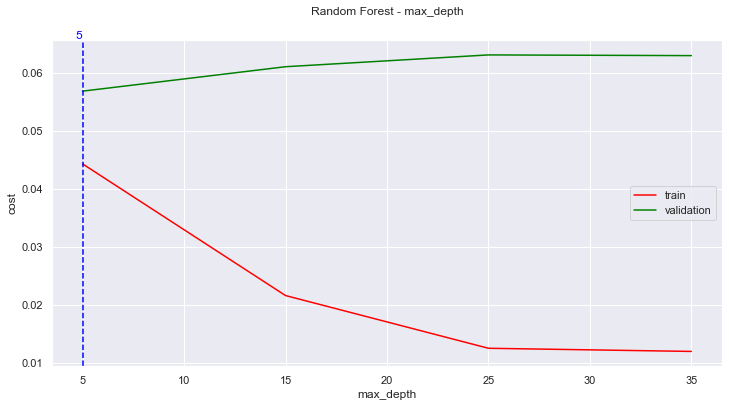

Fitting 5 folds for each of 3 candidates, totalling 15 fits


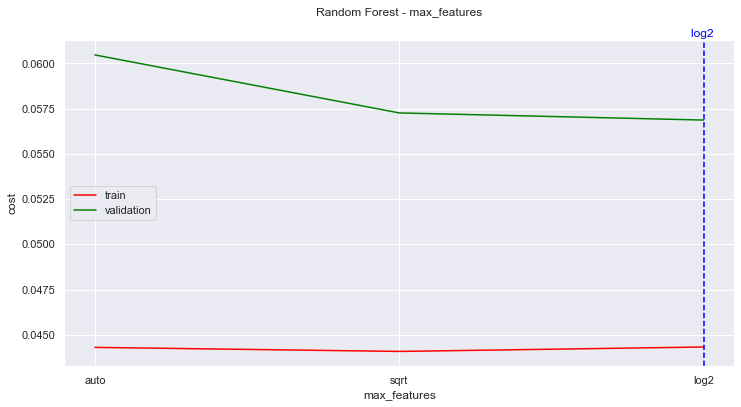

Fitting 5 folds for each of 3 candidates, totalling 15 fits


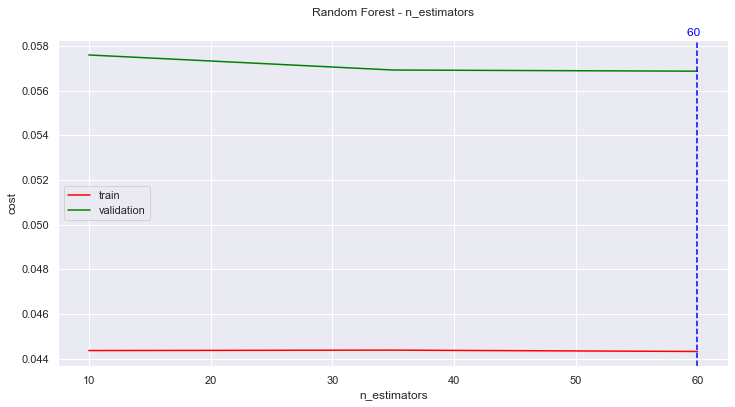


Model result for Random Forest
-------------------
Error score on cross-validation set: 5.69%
Error score on test set: 5.37%
Wall time: 12min 27s


In [143]:
%%time
model_random_forest = fit_GridSearchCV_model_based_on_existing_model(model_random_forest, grid_parameters=parameters_random_forest)
append_results_to_results_dataframe(model_random_forest, "Random Forest")
plot_cost_curve_for_all_parameters_per_model(model_random_forest, model_random_forest_initial, "Random Forest", parameters_random_forest)
print_model_results(model_random_forest, 'Random Forest')

#### Decision tree

In [144]:
model_decision_tree_initial = DecisionTreeRegressor(random_state=444444)
model_decision_tree = DecisionTreeRegressor(random_state=444444)
parameters_decision_tree = {
    'splitter' : ["best", "random"],
    'max_depth' : np.arange(1, 20, 2),
    'min_samples_split' : np.arange(1, 10, 1)
    }

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


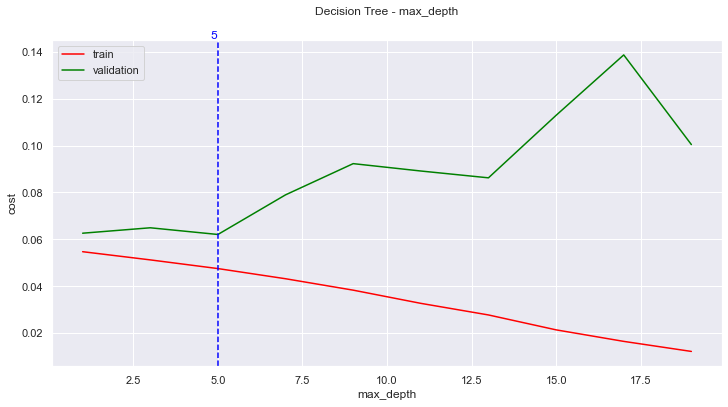

Fitting 5 folds for each of 9 candidates, totalling 45 fits


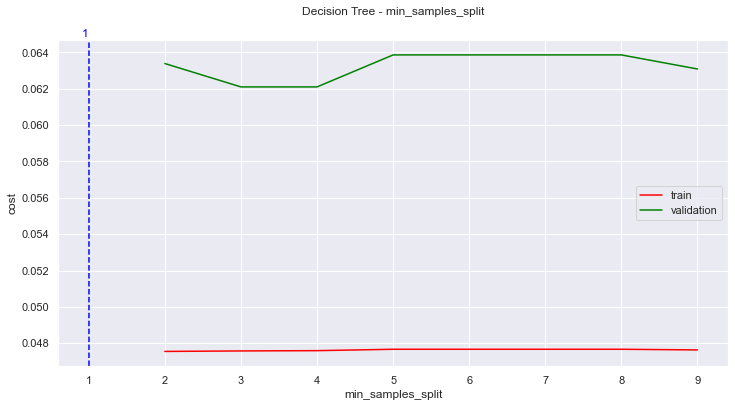

Fitting 5 folds for each of 2 candidates, totalling 10 fits


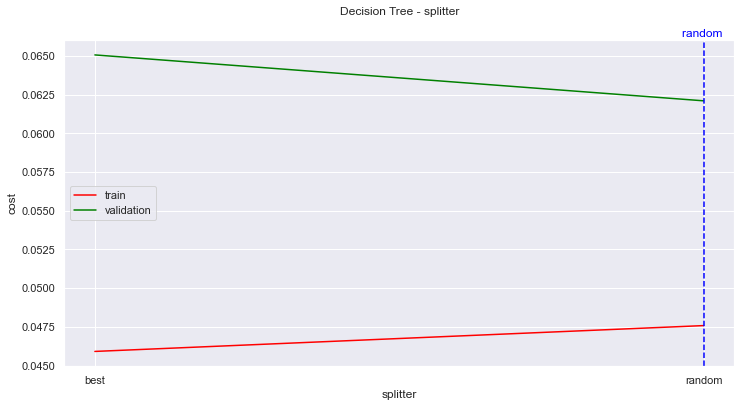


Model result for Decision Tree
-------------------
Error score on cross-validation set: 6.21%
Error score on test set: 5.53%
Wall time: 2min 17s


In [145]:
%%time
model_decision_tree = fit_GridSearchCV_model_based_on_existing_model(model_decision_tree, grid_parameters=parameters_decision_tree)
append_results_to_results_dataframe(model_decision_tree, "Decision Tree")
plot_cost_curve_for_all_parameters_per_model(model_decision_tree, model_decision_tree_initial, "Decision Tree", parameters_decision_tree)
print_model_results(model_decision_tree, 'Decision Tree')

#### Linear regression - Lasso

In [146]:
model_lasso = Lasso()
model_lasso_initial = Lasso()
parameters_lasso = {'alpha' : np.arange(.01, 1, .05)}

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


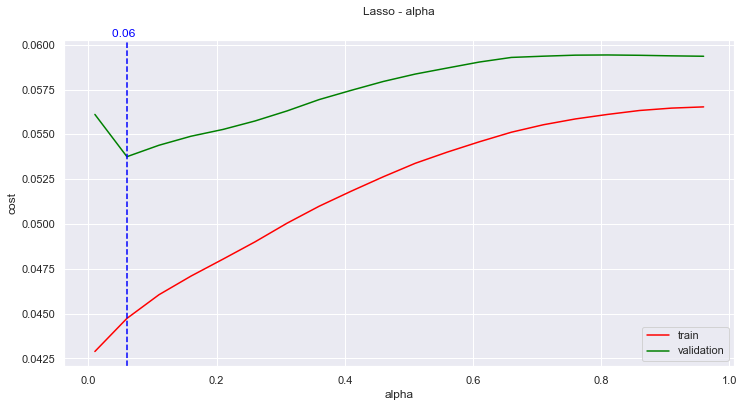


Model result for Lasso
-------------------
Error score on cross-validation set: 5.38%
Error score on test set: 5.23%
Wall time: 36.9 s


In [147]:
%%time
model_lasso = fit_GridSearchCV_model_based_on_existing_model(model_lasso, grid_parameters=parameters_lasso)
append_results_to_results_dataframe(model_lasso, "Lasso")
plot_cost_curve_for_all_parameters_per_model(model_lasso, model_lasso_initial, "Lasso", parameters_lasso)
print_model_results(model_lasso, 'Lasso')

#### Linear regression - Ridge

In [148]:
model_ridge = Ridge(random_state=444444)
model_ridge_initial = Ridge(random_state=444444)
parameters_ridge = {
    'alpha' : np.arange(.01, 1, .05),
    'normalize' : [True, False],
    'positive' : [True, False],
    'max_iter' : np.geomspace(10, 1000, num=4).astype('int'),
    'tol' : np.geomspace(1e-6, 1e-3, num=3),
    }

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


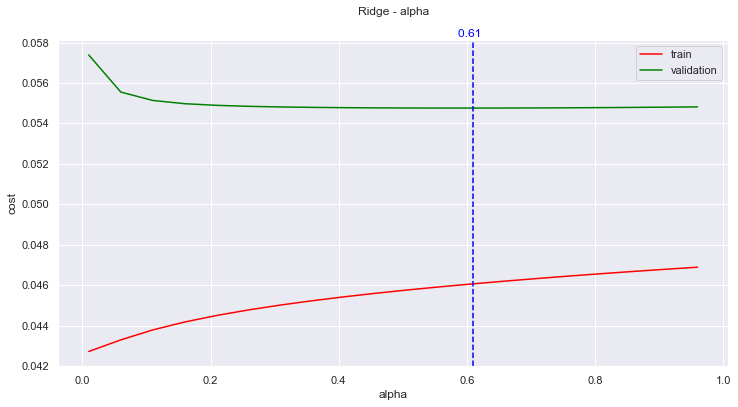

Fitting 5 folds for each of 4 candidates, totalling 20 fits


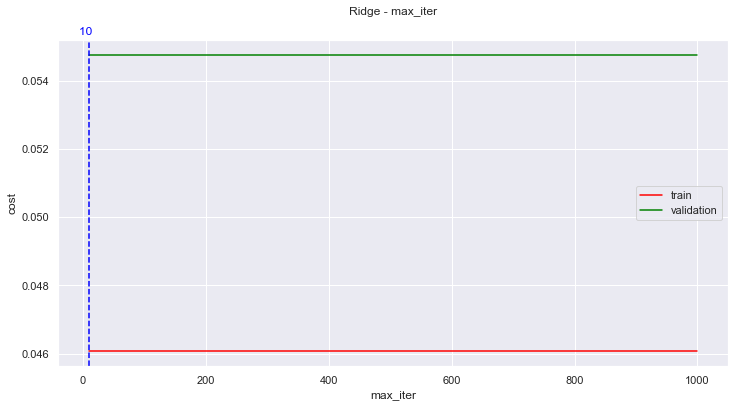

Fitting 5 folds for each of 2 candidates, totalling 10 fits


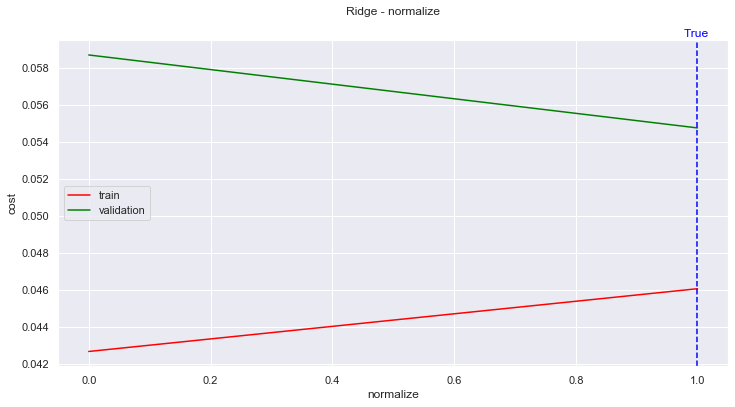

Fitting 5 folds for each of 2 candidates, totalling 10 fits


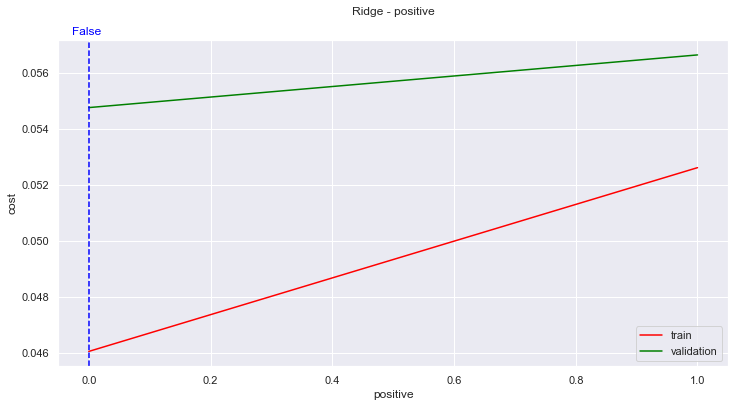

Fitting 5 folds for each of 3 candidates, totalling 15 fits


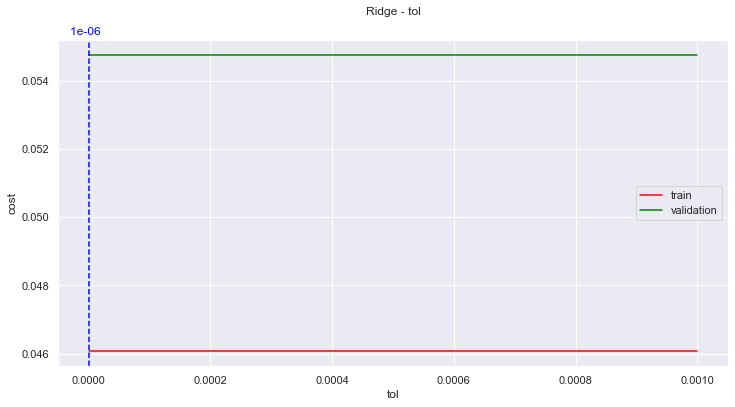


Model result for Ridge
-------------------
Error score on cross-validation set: 5.48%
Error score on test set: 5.31%
Wall time: 59.5 s


In [149]:
%%time
model_ridge = fit_GridSearchCV_model_based_on_existing_model(model_ridge, grid_parameters=parameters_ridge)
append_results_to_results_dataframe(model_ridge, "Ridge")
plot_cost_curve_for_all_parameters_per_model(model_ridge, model_ridge_initial, "Ridge", parameters_ridge)
print_model_results(model_ridge, 'Ridge')

#### Lasso Least-angle regression

In [150]:
model_lasso_lars = LassoLars(random_state=444444,
                              max_iter=10000
                              )
model_lasso_lars_initial = LassoLars(random_state=444444,
                              max_iter=10000
                                      )
parameters_lasso_lars = {
    'alpha' : np.arange(.01, 0.8, .1),
    # 'jitter' : list(np.arange(.01, 0.8, .1)),
    'normalize' : [True, False],
    'positive' : [True, False],
    'max_iter' : np.arange(5000, 15000, 2500),
    # 'tol' : np.geomspace(1e-6, 1e-4, num=2),
    }

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


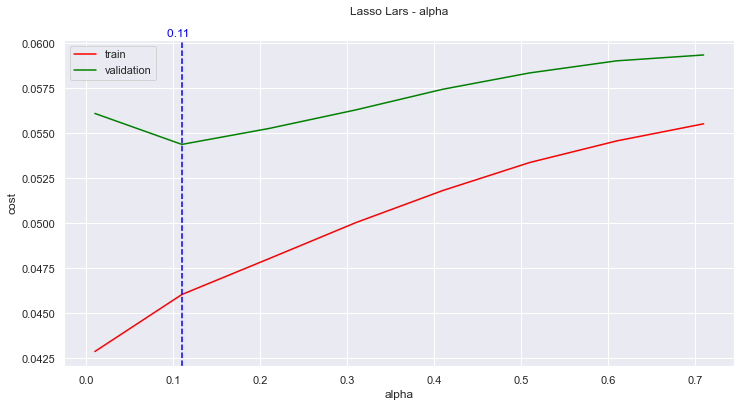

Fitting 5 folds for each of 4 candidates, totalling 20 fits


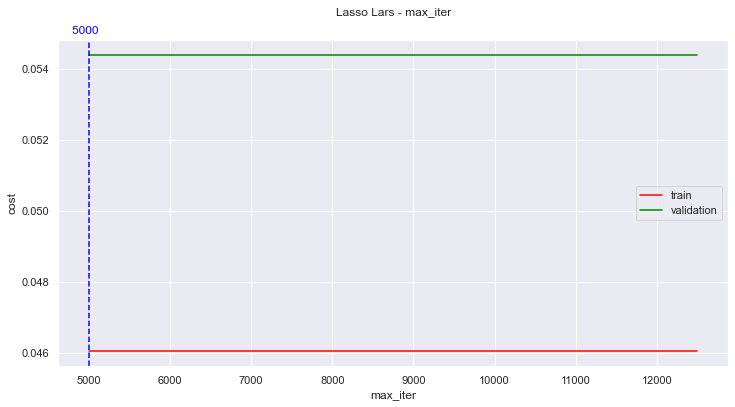

Fitting 5 folds for each of 2 candidates, totalling 10 fits


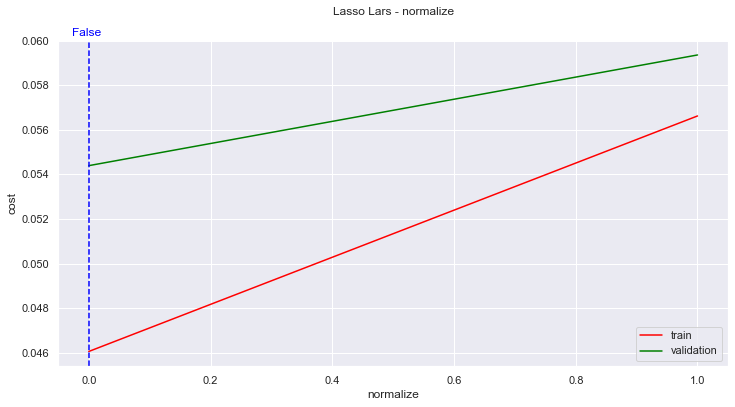

Fitting 5 folds for each of 2 candidates, totalling 10 fits


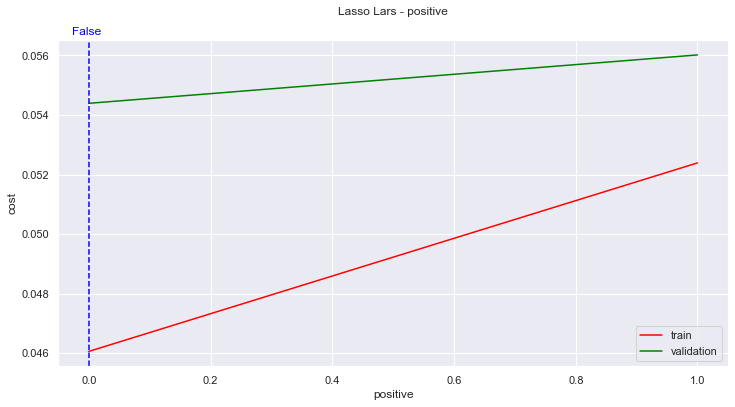


Model result for Lasso Lars
-------------------
Error score on cross-validation set: 5.44%
Error score on test set: 5.20%
Wall time: 8.01 s


In [151]:
%%time
model_lasso_lars = fit_GridSearchCV_model_based_on_existing_model(model_lasso_lars, grid_parameters=parameters_lasso_lars, verbose=1)
append_results_to_results_dataframe(model_lasso_lars, "Lasso Lars")
plot_cost_curve_for_all_parameters_per_model(model_lasso_lars, model_lasso_lars_initial, "Lasso Lars", parameters_lasso_lars)
print_model_results(model_lasso_lars, 'Lasso Lars')

#### Elastic Net regression

In [152]:
model_elastic_net = ElasticNet(random_state=444444,
                              max_iter=100
                              )
model_elastic_net_initial = ElasticNet(random_state=444444,
                              max_iter=100
                                      )
parameters_elastic_net = {
    'alpha' : np.arange(.01, 0.8, .1),
    'l1_ratio' : np.arange(.01, 0.8, .1),
    'normalize' : [True, False],
    'positive' : [True, False],
    }

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


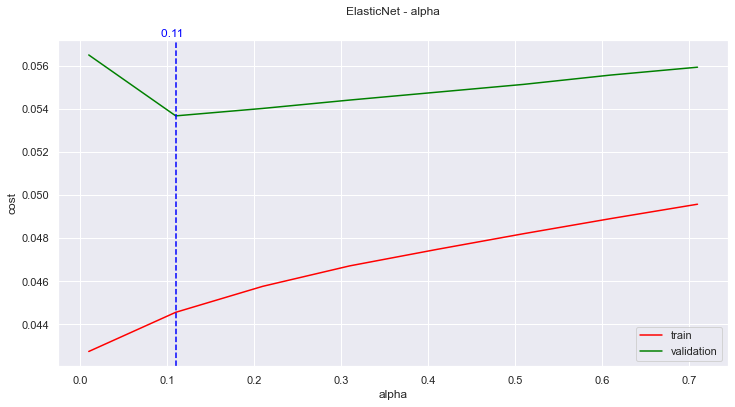

Fitting 5 folds for each of 8 candidates, totalling 40 fits


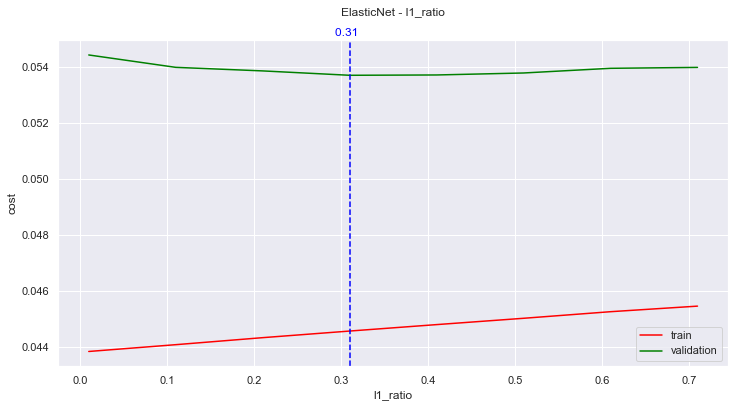

Fitting 5 folds for each of 2 candidates, totalling 10 fits


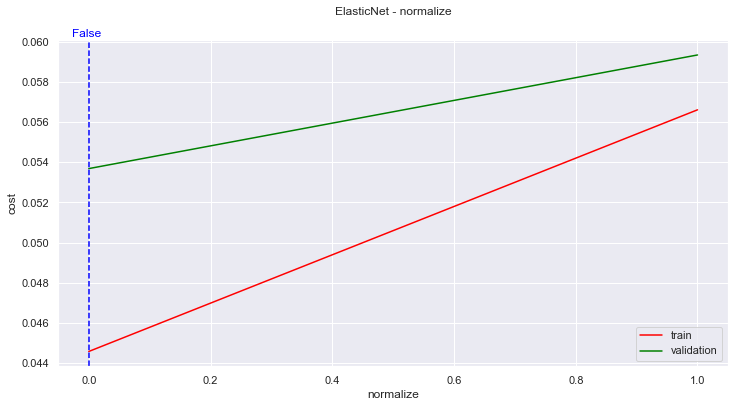

Fitting 5 folds for each of 2 candidates, totalling 10 fits


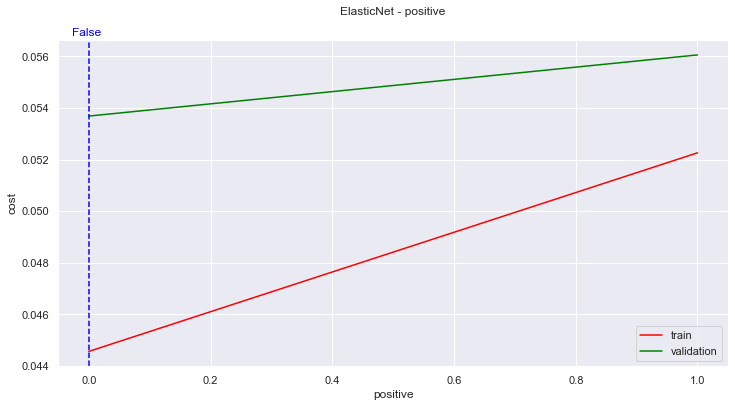


Model result for ElasticNet
-------------------
Error score on cross-validation set: 5.37%
Error score on test set: 5.27%
Wall time: 3min 35s


In [153]:
%%time
model_elastic_net = fit_GridSearchCV_model_based_on_existing_model(model_elastic_net, grid_parameters=parameters_elastic_net)
append_results_to_results_dataframe(model_elastic_net, "ElasticNet")
plot_cost_curve_for_all_parameters_per_model(model_elastic_net, model_elastic_net_initial, "ElasticNet", parameters_elastic_net)
print_model_results(model_elastic_net, 'ElasticNet')

### Results

We have trained several models,  
Now let's look at the results.

In [154]:
df_model_result['Score on CV'] = df_model_result['Score on CV'].map('{:.2%}'.format)
df_model_result['Score on Test Tet'] = df_model_result['Score on Test Tet'].map('{:.2%}'.format)
df_model_result = df_model_result.reset_index(drop=True)

In [155]:
display(df_model_result.sort_values(by='Score on Test Tet', ascending=True))

,Model,Score on CV,Score on Test Tet
5,Lasso Lars,5.44%,5.20%
3,Lasso,5.38%,5.23%
6,ElasticNet,5.37%,5.27%
4,Ridge,5.48%,5.31%
1,Random Forest,5.69%,5.37%
0,Linear Regression,5.87%,5.41%
2,Decision Tree,6.21%,5.53%


In [156]:
model = model_lasso_lars

It looks like the winning model is:  
**Lasso LARS Linear Regression**  
With the error **score of 5.20%** on the test set.

### Sanity check

Now once we have a winner model,  
Let's check its performance against a dummy regressor.  
I'll use the scikit-learn built in DummyRegressor model, which by default returns the mean of the train set targets.

In [157]:
model_dummy = DummyRegressor()
model_dummy.fit(X_train, y_train)
dummy_score = final_smape(model_dummy.predict(X_test), y_test)

Now once we have the regression lets print out the score

In [158]:
print("Score for the dummy regressor: {:.2%}".format(dummy_score))

Score for the dummy regressor: 5.71%


Our sanity check model returned score of 5.71%.  
Which means our trained **Lasso-LARS regression model performs better**.

## Conclusion

In this project we build a model to predict gold recovery percentage in a flotation process depending on various features like airflow level.  


First we loaded the datasets and checked the data integrity:
* We ensured that recovery column was calculated correctly veryfing with the original formula and other parameters we have
* We checked that the full dataset contains data from train and test sets
* We analyzed features that were absent in the test set and filled the set with them as well as with the target values


Then we performed data preprocessing: 
* We analyzed missing values
* We removed rows with missing targets in order to not distort the data
* We filled the other missing data with KNN imputer
* We checked that there are no duplicate values in the data


We analyzed how metal concentration distributions were different for each metal and for each stage.  

We saw how different metals react differently to the process:
* Gold concentration increased at each stage
* That wasn't the case however for Silver and Lead, that had concentrations increased at 1st stage, but then the increase wasn't consistant accross all stages
* We saw anomaly that many metals in some stages had 0% of concentrations, which makes no sense
* We removed the extra small values as outliers

Then we proceede to the model training step:  
* We build 7 different models  each of them using GridSearchCV in order to find the best hyperparameters.  
* We chose sMAPE as out cost function, but first implemented the formula in a punction final_smape().  
* Then we chose the model that performed the best:
  Lasso-LARS regression with error score of 5.20% on the test set.  
* The final step was to check the model against a dummy estimator for a sanity check, and the dummy estimator gave us a score of 5.71% error.  

The conclusion is that our model performed better. Sanity check passed.